In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV



# Data Collection

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Rakamin/loan_data_2007_2014.csv",low_memory=False)

In [5]:
df = df.drop("Unnamed: 0",axis = 1)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Understanding

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

## Missing Values Treatment and Duplicate Data

kolom yang tidak akan dipakai adalah:


*   dti_joint, annual_inc_joint, dan verification_status_joint karena tidak ada pinjaman atas 2 orang atau lebih (karena seluruh tipe application bersifat Individual)
*   mths_since_rcnt_il,il_util,total_bal_il, open_il_6m,open_il_12m,open_il_24m karena tidak ada rekening angsuran (ditandai dengan jumlah saldo pada semua rekening angsuran)
*   open_acc_6m,open_rv_12m,open_rv_24m,total_cu_tl,all_util karena tidak ada perdagangan
*  inq_fi,inq_last_12m karena null, artinya memang tidak ada pengajuan pertanyaan terhadap peminjam terkait kondisi keuangan pribadi dan juga pertanyaan kredit selama 12 bulan.
* max_bal_bc karena tidak ada yang sampai maksimum pada semua akun.


In [7]:
full_null = [col for col in df.columns if df[col].isnull().all()]

selected_df = df.drop(columns = full_null, axis = 1)
selected_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [8]:
def percentage(orders_df):
    # Hitung persentase nilai yang hilang
    missing = orders_df.isnull().sum() * 100 / len(orders_df)

    # Buat dataframe untuk nilai yang hilang dan filter hanya kolom yang memiliki nilai yang hilang
    percentage_missing = pd.DataFrame({'column': orders_df.columns,
                                       'missing_percentage %': missing.values})
    percentage_missing = percentage_missing[percentage_missing['missing_percentage %'] > 0]

    # Jika ada kolom yang memiliki nilai yang hilang
    if not percentage_missing.empty:
        # Bulatkan persentase nilai yang hilang
        percentage_missing['missing_percentage %'] = percentage_missing['missing_percentage %'].round(2)
        # Urutkan berdasarkan persentase nilai yang hilang
        percentage_missing = percentage_missing.sort_values('missing_percentage %', ascending=False)
        # Reset indeks
        percentage_missing = percentage_missing.reset_index(drop=True)

        return percentage_missing
    else:
        return pd.DataFrame(columns=['column', 'missing_percentage %'])

percentage(selected_df)

,column,missing_percentage %
0,mths_since_last_record,86.57
1,mths_since_last_major_derog,78.77
2,desc,72.98
3,mths_since_last_delinq,53.69
4,next_pymnt_d,48.73
5,total_rev_hi_lim,15.07
6,tot_cur_bal,15.07
7,tot_coll_amt,15.07
8,emp_title,5.92
9,emp_length,4.51


Fitur dengan **Missing Values > 50%**

1. mths_since_last_record : Jumlah bulan sejak catatan publik terakhir
2. mths_since_last_major_derog : Jumlah bulan sejak terakhir kali nasabah mengalami keterlambatan pembayaran 90 hari atau lebih
3. desc : Deskripsi alasan peminjaman
4. mths_since_last_delinq : Jumlah bulan sejak pelanggaran terakhir oleh peminjam

Fitur dengan **Missing Values > 40% dan < 50%**

- next_pymnt_d : Tanggal pembayaran dijadwalkan berikutnya

Fitur dengan **Missing Values > 1% dan < 20%**

1. total_rev_hi_lim : Total kredit / batas kredit tinggi bergulir
2. tot_cur_bal : Total saldo saat ini dari semua akun
3. tot_coll_amt : Jumlah total koleksi yang pernah ada
4. emp_title : Pekerjaan Peminjam
5. emp_length : Lama bekerja Peminjam

Berdasarkan persentase missing values di atas serta business understanding dari masing-masing kolom di atas, maka perlu adanya penanganan missing values berdasarkan kolomnya, yaitu:

- mths_since_last_major_derog = 0 untuk mengganti null karena null dianggap tidak ada pelanggaran sejak 90 hari terakhir

- mths_since_last_delinq = 0 untuk mengganti null, karena null dianggap bahwa tidak ada pelanggaran yang dilakukan dalam beberapa bulan.

- emp_length = yang null diganti dengan nilai median dari emp_length, mengambil nilai tengah dari persebaran data emp_length.

- revol_util = yang null akan di drop karena pengaruh nilai revol_util sangat tinggi dalam prediksi credit score, sehingga lebih baik menjaga keaslian data.

- collections_12_mths_ex_med = akan didrop untuk menjaga keaslian data.

- delinq_2yrs = akan didrop untuk menjaga keaslian data.

- acc_now_delinq = akan di drop untuk menjaga keaslian data.

- total_acc = akan di drop untuk menjaga keaslian data.

In [9]:
# Cleaned Data
df_cleaned = selected_df.copy()

df_cleaned['mths_since_last_major_derog'].fillna(0, inplace=True)
df_cleaned['mths_since_last_delinq'].fillna(0, inplace=True)
df_cleaned.dropna(subset=['revol_util'], inplace=True)

columns_to_drop_rows = ['collections_12_mths_ex_med', 'delinq_2yrs', 'acc_now_delinq', 'total_acc']
df_cleaned.dropna(subset=columns_to_drop_rows, inplace=True)

df_cleaned[['mths_since_last_major_derog','mths_since_last_delinq']].isna().sum()

mths_since_last_major_derog    0
mths_since_last_delinq         0
dtype: int64

Untuk numerik lainnya, nilai nulls akan diganti dengan median

In [10]:
for col in df_cleaned.select_dtypes(exclude='object'):
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
df_cleaned.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       27545
emp_length                      20996
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           340080
purpose                             0
title                              21
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
earliest_cr_

Untuk kolom kategori atau objek, nilai null diganti dengan kategori dengan jumlah terbanyak / modusnya

In [11]:
obj_col = []
for kolom in df_cleaned.select_dtypes(include='object'):
    df_cleaned[kolom] = df_cleaned[kolom].fillna(df_cleaned[kolom].mode().iloc[0])
    obj_col.append(kolom)
print("Jumlah Nilai yang Hilang setelah Pembaruan")
df_cleaned[obj_col].isnull().sum()

Jumlah Nilai yang Hilang setelah Pembaruan


term                   0
grade                  0
sub_grade              0
emp_title              0
emp_length             0
home_ownership         0
verification_status    0
issue_d                0
loan_status            0
pymnt_plan             0
url                    0
desc                   0
purpose                0
title                  0
zip_code               0
addr_state             0
earliest_cr_line       0
initial_list_status    0
last_pymnt_d           0
next_pymnt_d           0
last_credit_pull_d     0
application_type       0
dtype: int64

In [12]:
duplicate_rows = df_cleaned[df_cleaned.duplicated()]

# Tampilkan baris-baris yang terduplikat
duplicate_rows.sum()

id                               0
member_id                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                0.0
term                             0
int_rate                       0.0
installment                    0.0
grade                            0
sub_grade                        0
emp_title                        0
emp_length                       0
home_ownership                   0
annual_inc                     0.0
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
url                              0
desc                             0
purpose                          0
title                            0
zip_code                         0
addr_state                       0
dti                            0.0
delinq_2yrs                    0.0
earliest_cr_line                 0
inq_last_6mths                 0.0
mths_since_last_deli

Tidak ada data yang terduplikat

# Data Preparation

## Categorization based on Loan Status

In [13]:
#Mengelompokkan Para Kreditur berdasarkan Loan Status
def categorize_loan_status(status):
    good_statuses = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
    bad_statuses = ['Charged Off',  'Default','Does not meet the credit policy. Status:Charged Off']
    undetecable_status = ['Current','In Grace Period','Late (31-120 days)','Late (16-30 days)']
    if status in good_statuses:
        return 'Good'
    elif status in bad_statuses:
        return 'Bad'
    else:
        return 'Other'

df_cleaned['loan_status_category'] = df_cleaned['loan_status'].apply(categorize_loan_status)
df_cleaned.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_category
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,Jan-16,0.0,0.0,1,INDIVIDUAL,0.0,0.0,81518.5,22900.0,Good
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,Sep-13,0.0,0.0,1,INDIVIDUAL,0.0,0.0,81518.5,22900.0,Bad
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,Jan-16,0.0,0.0,1,INDIVIDUAL,0.0,0.0,81518.5,22900.0,Good
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,Jan-15,0.0,0.0,1,INDIVIDUAL,0.0,0.0,81518.5,22900.0,Good
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,Jan-16,0.0,0.0,1,INDIVIDUAL,0.0,0.0,81518.5,22900.0,Other


Berdasarkan status yang diberikan, kategorisasi dapat dilakukan sebagai berikut:

1. Good (Baik):

  - 'Fully Paid': Pinjaman telah dilunasi sepenuhnya dan tepat waktu.

  - 'Does not meet the credit policy. Status
Paid': Pinjaman telah dilunasi sepenuhnya, tetapi tidak memenuhi kebijakan kredit.

2. Bad (Buruk):

  - 'Charged Off': Pinjaman dinyatakan sebagai kerugian karena tidak mungkin dilunasi oleh peminjam.
  - 'Default': Pinjaman telah gagal dilunasi dan dinyatakan gagal bayar.
  - 'Does not meet the credit policy. Status
Off': Pinjaman dinyatakan sebagai kerugian karena tidak memenuhi kebijakan kredit.

3. Other:
  - 'Late (31-120 days)': Peminjam mengalami keterlambatan pembayaran selama 31-120 hari.
  - 'In Grace Period': Peminjam berada dalam masa tenggang pembayaran.
  - Current : Sedang dalam masa peminjaman, tidak bisa dianggap Baik ataupun Buruk
  - 'Late (16-30 days)': Peminjam mengalami keterlambatan pembayaran selama 16-30 hari.

## Check Unique Values

In [14]:
df_cleaned["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

Ada spasi sebelum angka, perlu diperbaiki

In [15]:
df_cleaned['term'] = df_cleaned['term'].apply(lambda x: x.strip())
df_cleaned["term"].unique()

array(['36 months', '60 months'], dtype=object)

In [16]:
print("Nilai kategori Fitur Grade : \n",df_cleaned["grade"].unique())
print("Nilai kategori Fitur Sub-grade : \n",df_cleaned["sub_grade"].unique())

Nilai kategori Fitur Grade : 
 ['B' 'C' 'A' 'E' 'F' 'D' 'G']
Nilai kategori Fitur Sub-grade : 
 ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']


In [17]:
print("Lama Bekerja para Peminjam (Dalam Kategori): \n",df_cleaned["emp_length"].unique())
print("Kepemilikan Rumah para Peminjam : \n",df_cleaned["home_ownership"].unique())

Lama Bekerja para Peminjam (Dalam Kategori): 
 ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
Kepemilikan Rumah para Peminjam : 
 ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']


In [18]:
print("Status Verifikasi oleh LC : \n",df_cleaned["verification_status"].unique())
print("Tujuan Peminjam : \n",df_cleaned["purpose"].unique())
print("Tipe Pembayaran : \n",df_cleaned["pymnt_plan"].unique())

Status Verifikasi oleh LC : 
 ['Verified' 'Source Verified' 'Not Verified']
Tujuan Peminjam : 
 ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
Tipe Pembayaran : 
 ['n' 'y']


## Formatting Date Data into Numerical

* issue_d = Bulan didanainya pinjaman
* last_pymnt_d = Bulan terakhir pembayaran diterima

* earliest_cr_line = Bulan pembukaan jalur kredit pertama yang dilaporkan peminjam
* last_credit_pull_d = Bulan terakhir LC memeriksa kredit untuk pinjaman ini



Mengubah data bulan ketika masuk peminjaman (issue_d) dengan bulan terakhir pembayaran diterima (last_pymnt_d) menjadi waktu yang telah berlalu sejak pinjaman diberikan hingga pembayaran terakhir yang dilakukan dengan nama data payment_duration.

Membuat kolom baru bernaman credit_pull_time, menunjukkan berapa lama waktu yang telah berlalu sejak peminjam pertama kali membuka jalur kredit hingga pengecekan kredit terakhir yang dilakukan oleh LC

In [19]:
def correct_year(date):
    if date.year > 2016:
        date = date.replace(year=date.year - 100)
    return date

def calculate_month_difference(date1, date2):
    return (date1.year - date2.year) * 12 + (date1.month - date2.month)

def calculate_year_difference(date1, date2):
    return date1.year - date2.year

# Konversi kolom tanggal menjadi tipe datetime
df_cleaned['earliest_cr_line'] = pd.to_datetime(df_cleaned['earliest_cr_line'], format='%b-%y')
df_cleaned['earliest_cr_line'] = df_cleaned['earliest_cr_line'].apply(correct_year)
df_cleaned['issue_d'] = pd.to_datetime(df_cleaned['issue_d'], format='%b-%y')
df_cleaned['last_pymnt_d'] = pd.to_datetime(df_cleaned['last_pymnt_d'], format='%b-%y')
df_cleaned['last_credit_pull_d'] = pd.to_datetime(df_cleaned['last_credit_pull_d'], format='%b-%y')

print(df_cleaned[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']].head())


  earliest_cr_line    issue_d last_pymnt_d last_credit_pull_d
0       1985-01-01 2011-12-01   2015-01-01         2016-01-01
1       1999-04-01 2011-12-01   2013-04-01         2013-09-01
2       2001-11-01 2011-12-01   2014-06-01         2016-01-01
3       1996-02-01 2011-12-01   2015-01-01         2015-01-01
4       1996-01-01 2011-12-01   2016-01-01         2016-01-01


In [20]:
df_cleaned['payment_duration_months'] = df_cleaned.apply(lambda row: calculate_month_difference(row['last_pymnt_d'], row['issue_d']), axis=1)
df_cleaned['credit_age_years'] = df_cleaned.apply(lambda row: calculate_year_difference(row['last_credit_pull_d'], row['earliest_cr_line']), axis=1)
print(df_cleaned[['payment_duration_months', 'credit_age_years']].head())

   payment_duration_months  credit_age_years
0                       37                31
1                       16                14
2                       30                15
3                       37                19
4                       49                20


Kolom yang tidak dipakai selanjutnya adalah:
1. Desc : Hanya berisi deskripsi alasan peminjam, tidak akan mempengaruhi pembuatan model
2. mths_since_last_record : Sudah ada mths_since_last_major_derog sebagai data yang mewakili perilaku peminjam
3. next_pymnt_d : Hanya data mengenai tenggat waktu pembayaran selanjutnya, tidak mempengaruhi model.
4. url : hanya link url yang diklik oleh peminjam
5. zip_code : Kode pos tidak mempengaruhi model prediksi karena prediksi tidak didasari lokasi peminjam
6. id dan member_id : Tidak dipakai karena terlalu banyak nilai unique
7. issue_d, last_pymnt_d, earliest_cr_line, last_credit_pull_d : Tidak dipakai karena sudah ada 2 kolom baru yang mewakili hubungan keempat kolom ini.



In [21]:
columns_to_drop = ['desc', 'mths_since_last_record', 'next_pymnt_d', 'url', 'zip_code', 'id', 'member_id',
                   'issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d']

df_cleaned = df_cleaned.drop(columns=columns_to_drop)

print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 465832 entries, 0 to 466284
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    465832 non-null  int64  
 1   funded_amnt                  465832 non-null  int64  
 2   funded_amnt_inv              465832 non-null  float64
 3   term                         465832 non-null  object 
 4   int_rate                     465832 non-null  float64
 5   installment                  465832 non-null  float64
 6   grade                        465832 non-null  object 
 7   sub_grade                    465832 non-null  object 
 8   emp_title                    465832 non-null  object 
 9   emp_length                   465832 non-null  object 
 10  home_ownership               465832 non-null  object 
 11  annual_inc                   465832 non-null  float64
 12  verification_status          465832 non-null  object 
 13  loan

## Correlation Analysis

In [22]:
label_encoder = LabelEncoder()
df_cleaned_corr = df_cleaned.copy()
for column in df_cleaned_corr.columns:
    if df_cleaned_corr[column].dtype == 'object':
        df_cleaned_corr[column] = label_encoder.fit_transform(df_cleaned_corr[column].astype(str))

correlation_matrix = df_cleaned_corr.corr()
unique_correlation = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()

unique_correlation = unique_correlation[unique_correlation != 1.0]

sorted_correlation = pd.DataFrame(unique_correlation).reset_index()

sorted_correlation.columns = ["Variable_1", "Variable_2", "Correlation"]

print("\nUrutan korelasi dari yang tertinggi hingga terendah:")
print(sorted_correlation.head(45))


Urutan korelasi dari yang tertinggi hingga terendah:
                 Variable_1       Variable_2  Correlation
0             out_prncp_inv        out_prncp     0.999998
1                 loan_amnt      funded_amnt     0.998553
2               funded_amnt  funded_amnt_inv     0.996214
3               total_pymnt  total_pymnt_inv     0.995954
4                 loan_amnt  funded_amnt_inv     0.994452
5                     grade        sub_grade     0.977269
6                 sub_grade         int_rate     0.974211
7           total_rec_prncp      total_pymnt     0.956645
8           total_rec_prncp  total_pymnt_inv     0.952250
9                  int_rate            grade     0.952181
10              funded_amnt      installment     0.951752
11                loan_amnt      installment     0.949634
12              installment  funded_amnt_inv     0.947452
13  collection_recovery_fee       recoveries     0.800713
14              installment      total_pymnt     0.764269
15              in

In [23]:
col_unused = ['policy_code','emp_title','addr_state','application_type','title',
            'out_prncp_inv','funded_amnt','total_pymnt_inv','funded_amnt_inv','total_rec_prncp','out_prncp',
            'revol_bal','total_pymnt','recoveries','total_rec_int','total_acc','loan_amnt']

In [24]:
df_cleaned_new = df_cleaned.drop(col_unused, axis = 1).reset_index(drop=True)
df_cleaned_new.head()

,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_category,payment_duration_months,credit_age_years
0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Fully Paid,...,171.62,0.0,0.0,0.0,0.0,81518.5,22900.0,Good,37,31
1,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Charged Off,...,119.66,0.0,0.0,0.0,0.0,81518.5,22900.0,Bad,16,14
2,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Fully Paid,...,649.91,0.0,0.0,0.0,0.0,81518.5,22900.0,Good,30,15
3,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Fully Paid,...,357.48,0.0,0.0,0.0,0.0,81518.5,22900.0,Good,37,19
4,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Current,...,67.79,0.0,0.0,0.0,0.0,81518.5,22900.0,Other,49,20


In [25]:
df_cleaned_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465832 entries, 0 to 465831
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         465832 non-null  object 
 1   int_rate                     465832 non-null  float64
 2   installment                  465832 non-null  float64
 3   grade                        465832 non-null  object 
 4   sub_grade                    465832 non-null  object 
 5   emp_length                   465832 non-null  object 
 6   home_ownership               465832 non-null  object 
 7   annual_inc                   465832 non-null  float64
 8   verification_status          465832 non-null  object 
 9   loan_status                  465832 non-null  object 
 10  pymnt_plan                   465832 non-null  object 
 11  purpose                      465832 non-null  object 
 12  dti                          465832 non-null  float64
 13 

## Outlier Identification

In [26]:
# Dataframe yang berisi data numerik
numeric_df = df_cleaned_new.select_dtypes(exclude='object')

# Metode untuk mendeteksi outlier menggunakan Z-score
def detect_outliers_iqr(df_cleaned):
    Q1 = df_cleaned.quantile(0.25)
    Q3 = df_cleaned.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df_cleaned < lower_bound) | (df_cleaned > upper_bound)

outliers_iqr = detect_outliers_iqr(numeric_df)

len_before_remove_outlier = len(df_cleaned_new.select_dtypes(exclude='object'))

# Menampilkan outlier
print("Outliers using IQR method:")
print(outliers_iqr.sum())


Outliers using IQR method:
int_rate                        4898
installment                    11695
annual_inc                     19868
dti                               34
delinq_2yrs                    83209
inq_last_6mths                 36728
mths_since_last_delinq         16762
open_acc                       10438
pub_rec                        61338
revol_util                        19
total_rec_late_fee             10632
collection_recovery_fee        23154
last_pymnt_amnt                70231
collections_12_mths_ex_med      3913
mths_since_last_major_derog    98816
acc_now_delinq                  1729
tot_coll_amt                   49731
tot_cur_bal                    21044
total_rev_hi_lim               32934
payment_duration_months         5218
credit_age_years               13494
dtype: int64


Plot outliers menggunakan BoxPlot

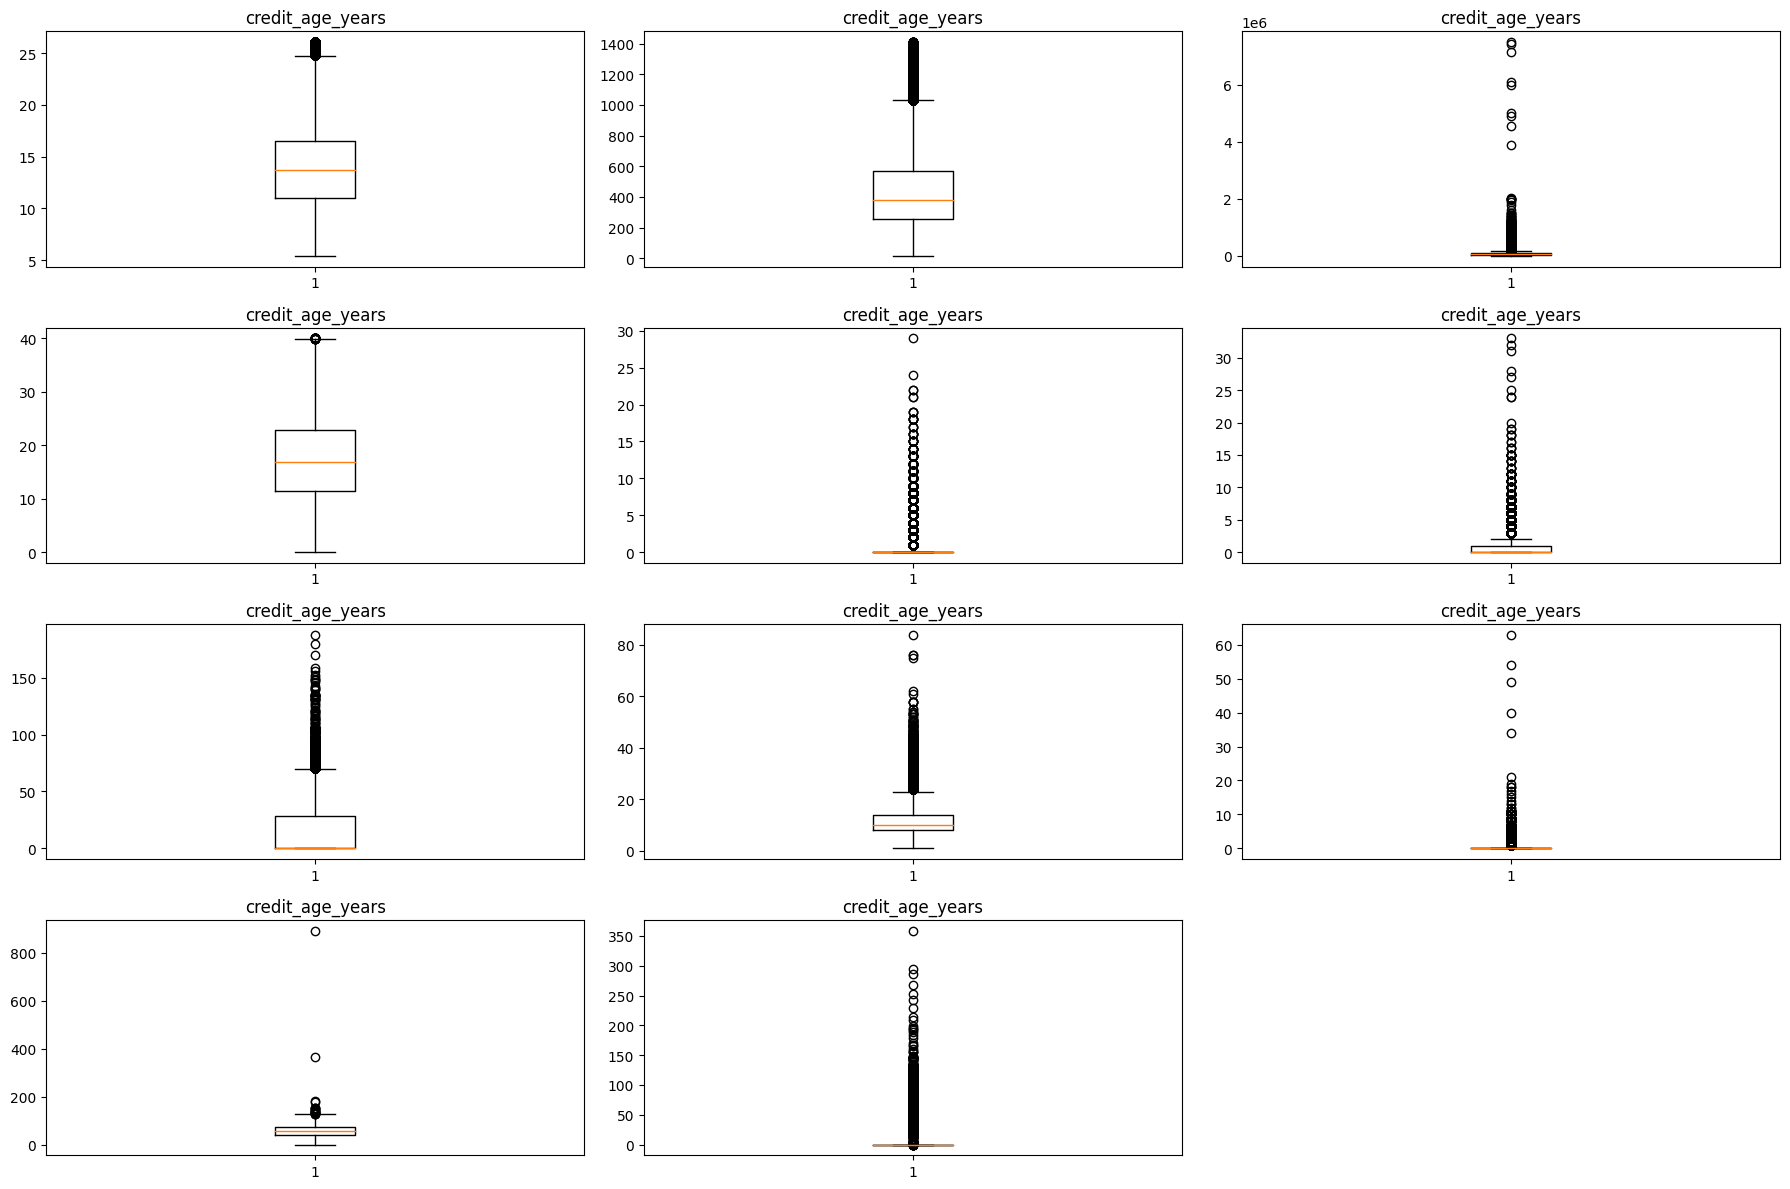

In [27]:
plt.figure(figsize=(18, 12))
for i in range(0,11):
    plt.subplot(4, 3, i + 1)
    plt.boxplot(numeric_df.iloc[:,i])
    plt.title(column)
plt.tight_layout()
plt.show()

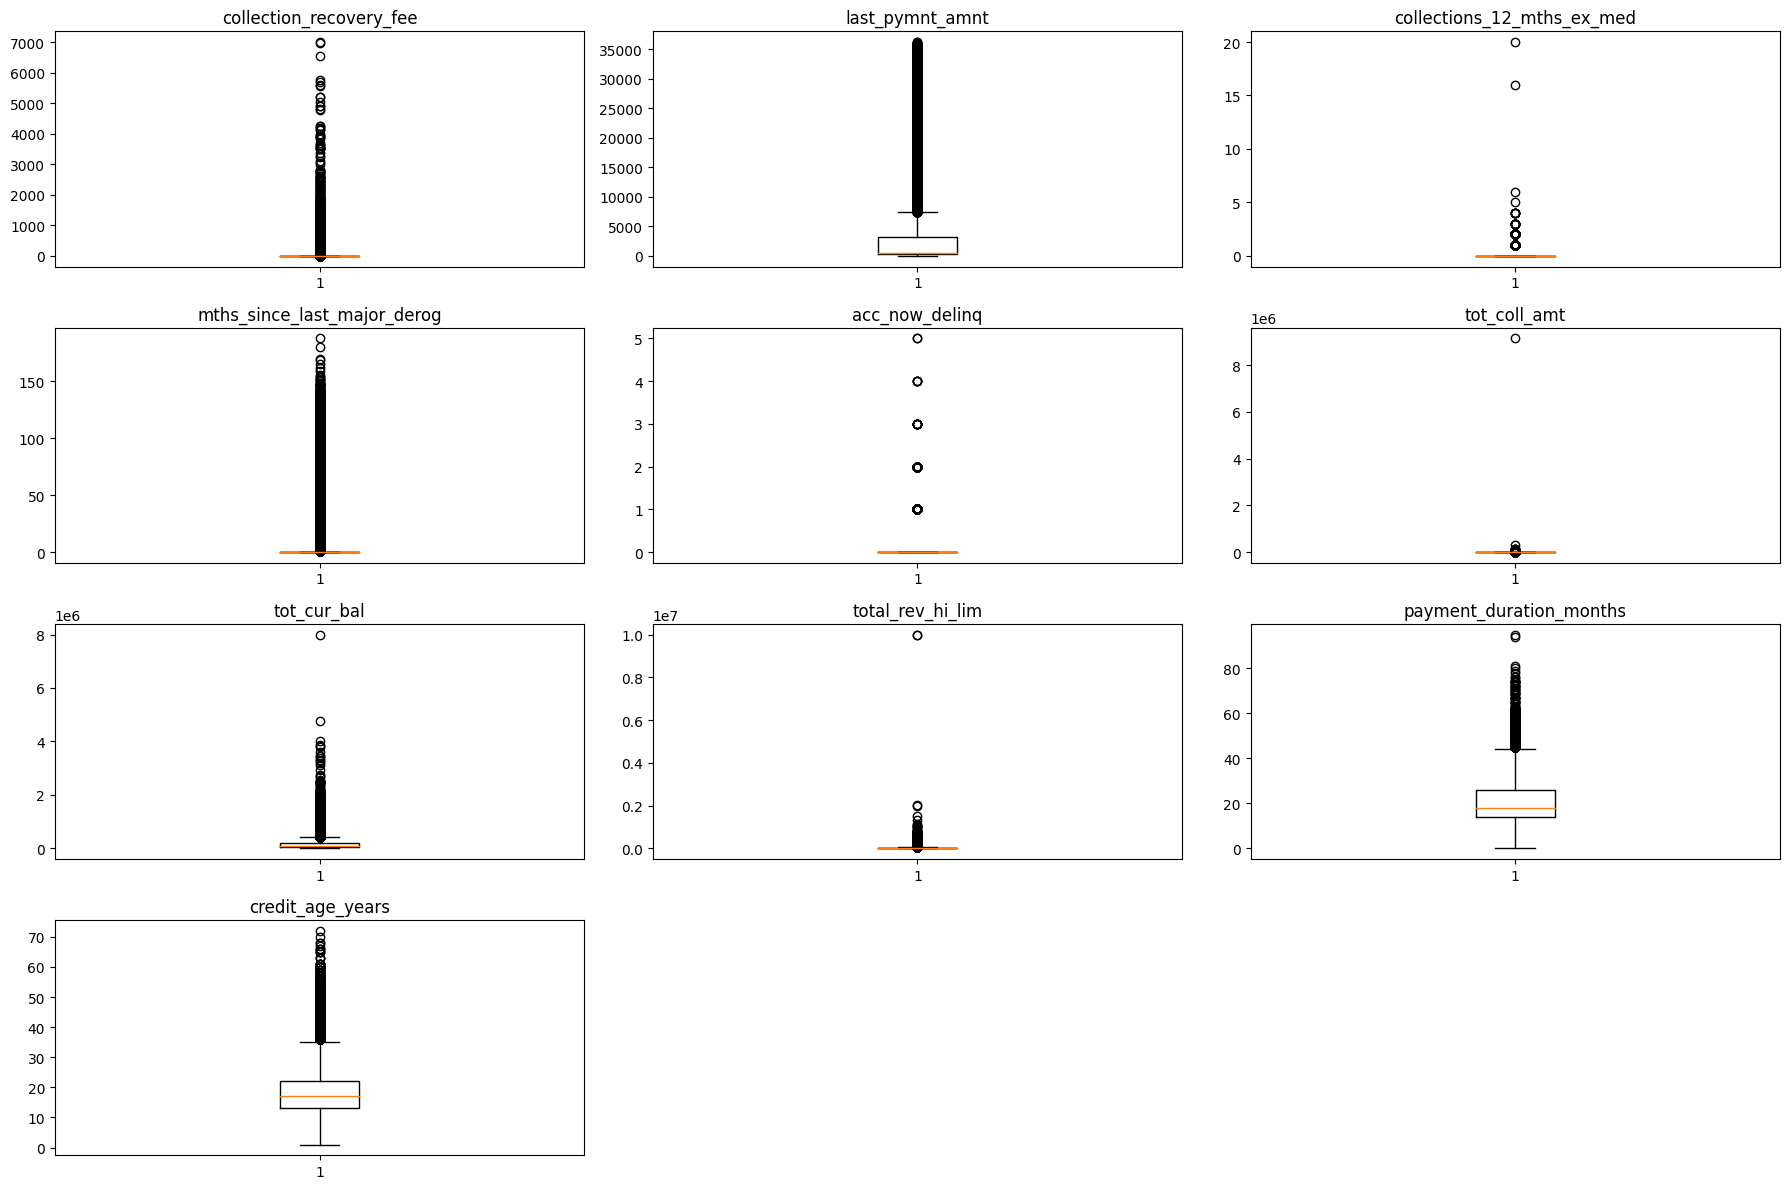

In [28]:
plt.figure(figsize=(18, 12))
for i, column in enumerate(numeric_df.columns[11:22]):
    plt.subplot(4, 3, i + 1)
    plt.boxplot(numeric_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

Berdasarkan menghitung jumlah outlier menggunakan IQR, dan juga melihat visualisasinya menggunakan boxplot, dapat dilihat bahwa masih ada fitur-fitur yang memiliki jumlah outlier yang cukup banyak, yaitu:

* int_rate                        4898
* installment                    11695
* annual_inc                     19868
* dti                               34
* delinq_2yrs                    83209
* inq_last_6mths                 36728
* mths_since_last_delinq         16762
* open_acc                       10438
* pub_rec                        61338
* revol_util                        19
* total_rec_late_fee             10632
* collection_recovery_fee        23154
* last_pymnt_amnt                70231
* collections_12_mths_ex_med      3913
* mths_since_last_major_derog    98816
* acc_now_delinq                  1729
* tot_coll_amt                   49731
* tot_cur_bal                    21044
* total_rev_hi_lim               32934
* payment_duration_months         5218
* credit_age_years               13494



Untuk fitur lainnya, nilai outliers akan dibuang saja, karena jumlahnya tidak mencapai 5% dari keseluruhan data.

In [29]:
from collections import Counter

def handle_outliers_iqr(df, features):
    outlier_indices = []

    # Iterate over features (columns)
    for col in features:
        # Calculate quartiles
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        # Calculate IQR
        IQR = Q3 - Q1
        # Determine outliers based on IQR
        outlier_list_col = df.index[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)].tolist()
        # Append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than specified number of outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > 0]

    return multiple_outliers

# List of features to be used for outlier detection
features = ['installment','annual_inc','open_acc','total_rec_late_fee','last_pymnt_amnt','total_rev_hi_lim',
           'tot_coll_amt','collection_recovery_fee','tot_cur_bal','payment_duration_months','credit_age_years']
# Detect outliers using IQR method
outliers_to_drop = handle_outliers_iqr(df_cleaned_new, features)

df_cleaned_new = df_cleaned_new.drop(outliers_to_drop, axis=0).reset_index(drop=True)

print("Outliers using IQR method:")
print(outliers_to_drop)


Outliers using IQR method:
[128, 185, 276, 611, 758, 759, 964, 1113, 1256, 1352, 1477, 1533, 1686, 1811, 1942, 1990, 1999, 2036, 2133, 2306, 2462, 2629, 2930, 2968, 2970, 3010, 3018, 3031, 3055, 3103, 3137, 3218, 3257, 3319, 3334, 3374, 3444, 3493, 3523, 3714, 4150, 4179, 4242, 4278, 4294, 4463, 4514, 4532, 4563, 4580, 4631, 4643, 4650, 4851, 4870, 4934, 4940, 4970, 5076, 5078, 5080, 5149, 5180, 5283, 5322, 5335, 5404, 5595, 5686, 5802, 5815, 5921, 5965, 6107, 6120, 6131, 6296, 6445, 6451, 6574, 7025, 7121, 7160, 7229, 7376, 7478, 7479, 7488, 7577, 7635, 7650, 7657, 7685, 7849, 7932, 7934, 8006, 8045, 8149, 8154, 8378, 8380, 8386, 8393, 8445, 8632, 8684, 8859, 9021, 9079, 9160, 9218, 9381, 9487, 9511, 9584, 9759, 9810, 9893, 9908, 9969, 10016, 10020, 10034, 10047, 10087, 10250, 10287, 10327, 10357, 10590, 10603, 10811, 11097, 11229, 11356, 11520, 11699, 11927, 11939, 11993, 11994, 12169, 12353, 12418, 12596, 12693, 12865, 12931, 12952, 12983, 12995, 13016, 13200, 13418, 13513, 13723, 1

In [30]:
outliers_iqr = detect_outliers_iqr(df_cleaned_new.select_dtypes(exclude='object'))

# Menampilkan outlier
print("Outliers using IQR method:")
print(outliers_iqr.sum())

Outliers using IQR method:
int_rate                        2232
installment                     4493
annual_inc                      6439
dti                                0
delinq_2yrs                    44268
inq_last_6mths                 18139
mths_since_last_delinq         11930
open_acc                        1293
pub_rec                        35664
revol_util                        10
total_rec_late_fee                 0
collection_recovery_fee            0
last_pymnt_amnt                50999
collections_12_mths_ex_med       635
mths_since_last_major_derog    53040
acc_now_delinq                   830
tot_coll_amt                       0
tot_cur_bal                    10278
total_rev_hi_lim               11154
payment_duration_months            0
credit_age_years                2569
dtype: int64


In [31]:
len_after_remove_outlier = len((df_cleaned_new.select_dtypes(exclude='object')))

print(f'Jumlah baris sebelum adanya penanganan outlier: {len_before_remove_outlier}')
print(f'Jumlah baris setelah adanya penanganan outlier: {len_after_remove_outlier}')

Jumlah baris sebelum adanya penanganan outlier: 465832
Jumlah baris setelah adanya penanganan outlier: 265556


In [32]:
df_after_outlier = df_cleaned_new.copy()

## Label Encoder Treatment

Melakukan penyederhanaan kategori pada data objec

In [33]:
obj_columns = df_cleaned_new.select_dtypes(include='object')
obj_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265556 entries, 0 to 265555
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   term                  265556 non-null  object
 1   grade                 265556 non-null  object
 2   sub_grade             265556 non-null  object
 3   emp_length            265556 non-null  object
 4   home_ownership        265556 non-null  object
 5   verification_status   265556 non-null  object
 6   loan_status           265556 non-null  object
 7   pymnt_plan            265556 non-null  object
 8   purpose               265556 non-null  object
 9   initial_list_status   265556 non-null  object
 10  loan_status_category  265556 non-null  object
dtypes: object(11)
memory usage: 22.3+ MB


In [34]:
print(df_cleaned_new['term'].unique())

#ubah menjadi angka
label_encoder = LabelEncoder()
label_encoder.fit(df_cleaned_new['term'])
df_cleaned_new['term'] = label_encoder.transform(df_cleaned_new['term'])

print(df_cleaned_new['term'].unique())


['36 months' '60 months']
[0 1]


In [35]:
print(df_cleaned_new['grade'].unique())

#ubah menjadi angka

label_mapping = {'A':6,
               'B':5,
               'C':4,
               'D':3,
               'E':2,
               'F':1,
               'G':0}

df_cleaned_new['grade'] = df_cleaned_new['grade'].map(label_mapping)

print(df_cleaned_new['grade'].unique())

['B' 'C' 'A' 'E' 'D' 'F' 'G']
[5 4 6 2 3 1 0]


In [36]:
def create_sub_grade_function(letter):
    def f(row):
        if row == f'{letter}1':
            val = 1
        elif row == f'{letter}2':
            val = 2
        elif row == f'{letter}3':
            val = 3
        elif row == f'{letter}4':
            val = 4
        elif row == f'{letter}5':
            val = 5
        else:
            val = 0
        return val
    return f

# Membuat fungsi-fungsi baru untuk setiap huruf
f_A = create_sub_grade_function('A')
f_B = create_sub_grade_function('B')
f_C = create_sub_grade_function('C')
f_D = create_sub_grade_function('D')
f_E = create_sub_grade_function('E')
f_F = create_sub_grade_function('F')
f_G = create_sub_grade_function('G')

# Mengaplikasikan fungsi-fungsi baru ke DataFrame
df_cleaned_new['SubGrade_A'] = df_cleaned_new["sub_grade"].apply(f_A)
df_cleaned_new['SubGrade_B'] = df_cleaned_new["sub_grade"].apply(f_B)
df_cleaned_new['SubGrade_C'] = df_cleaned_new["sub_grade"].apply(f_C)
df_cleaned_new['SubGrade_D'] = df_cleaned_new["sub_grade"].apply(f_D)
df_cleaned_new['SubGrade_E'] = df_cleaned_new["sub_grade"].apply(f_E)
df_cleaned_new['SubGrade_F'] = df_cleaned_new["sub_grade"].apply(f_F)
df_cleaned_new['SubGrade_G'] = df_cleaned_new["sub_grade"].apply(f_G)

# Menghapus kolom "sub_grade" dari DataFrame
df_cleaned_new = df_cleaned_new.drop(columns="sub_grade")

In [37]:
df_cleaned_new.head(5)

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,...,loan_status_category,payment_duration_months,credit_age_years,SubGrade_A,SubGrade_B,SubGrade_C,SubGrade_D,SubGrade_E,SubGrade_F,SubGrade_G
0,0,10.65,162.87,5,10+ years,RENT,24000.0,Verified,Fully Paid,n,...,Good,37,31,0,2,0,0,0,0,0
1,0,15.96,84.33,4,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,...,Good,30,15,0,0,5,0,0,0,0
2,0,7.90,156.46,6,3 years,RENT,36000.0,Source Verified,Fully Paid,n,...,Good,37,11,4,0,0,0,0,0,0
3,0,18.64,109.43,2,9 years,RENT,48000.0,Source Verified,Fully Paid,n,...,Good,37,7,0,0,0,0,1,0,0
4,1,14.65,153.45,4,5 years,OWN,72000.0,Not Verified,Fully Paid,n,...,Good,18,17,0,0,3,0,0,0,0


In [38]:
print(df_cleaned_new["emp_length"].unique())

label_mapping = {'< 1 year':0,
               '1 year':1,
               '2 years':2,
               '3 years':3,
               '4 years':4,
               '5 years':5,
               '6 years':6,
               '7 years':7,
               '8 years':8,
               '9 years':9,
               '10+ years':10}

df_cleaned_new["emp_length"] = df_cleaned_new["emp_length"].map(label_mapping)

['10+ years' '3 years' '9 years' '5 years' '< 1 year' '4 years' '2 years'
 '7 years' '1 year' '6 years' '8 years']


In [39]:
print(df_cleaned_new["home_ownership"].unique())

print("\n Mengelompokkan Kategori Other, ANY, dan None menjadi 1 kategori dengan nama OTHER \n")

label_mapping = {'MORTGAGE':'MORTGAGE',
               'RENT':'RENT',
               'OWN':'OWN',
               'OTHER':'OTHER',
               'ANY':'OTHER',
               'NONE':'OTHER'}

df_cleaned_new["home_ownership"] = df_cleaned_new["home_ownership"].map(label_mapping)

print(df_cleaned_new["home_ownership"].unique())

to_number = {'MORTGAGE': 0,
               'RENT':1,
               'OWN':2,
               'OTHER':3}

df_cleaned_new["home_ownership"] = df_cleaned_new["home_ownership"].map(to_number)
print(df_cleaned_new["home_ownership"].unique())



['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']

 Mengelompokkan Kategori Other, ANY, dan None menjadi 1 kategori dengan nama OTHER 

['RENT' 'OWN' 'MORTGAGE' 'OTHER']
[1 2 0 3]


In [40]:
print(df_cleaned_new["verification_status"].unique())

label_mapping = {'Verified': 0,
                 'Not Verified': 1,
                 'Source Verified':2}
df_cleaned_new["verification_status"] = df_cleaned_new["verification_status"].map(label_mapping)

print(df_cleaned_new["verification_status"].unique())

['Verified' 'Not Verified' 'Source Verified']
[0 1 2]


In [41]:
print(df_cleaned_new['pymnt_plan'].unique())

#ubah menjadi angka
label_encoder = LabelEncoder()
label_encoder.fit(df_cleaned_new['pymnt_plan'])
df_cleaned_new['pymnt_plan'] = label_encoder.transform(df_cleaned_new['pymnt_plan'])

print(df_cleaned_new['pymnt_plan'].unique())

['n' 'y']
[0 1]


In [42]:
df_cleaned_new = df_cleaned_new.drop('loan_status',axis = 1)

In [43]:
df_cleaned_new = df_cleaned_new[df_cleaned_new['loan_status_category'] != 'Other']
df_cleaned_new['loan_status_category'].unique()

array(['Good', 'Bad'], dtype=object)

In [44]:
print(df_cleaned_new['loan_status_category'].unique())

#ubah menjadi angka
label_encoder = LabelEncoder()
label_encoder.fit(df_cleaned_new['loan_status_category'])
df_cleaned_new['loan_status_category'] = label_encoder.transform(df_cleaned_new['loan_status_category'])

print(df_cleaned_new['loan_status_category'].unique())

['Good' 'Bad']
[1 0]


In [45]:
print(df_cleaned_new['purpose'].unique())

# Define a dictionary for aggregating variable
label_mapping = {
    'debt_consolidation': 'debt_consolidation',
    'credit_card': 'credit_card',
    'home_improvement': 'private_use',
    'car': 'private_use',
    'medical': 'private_use',
    'wedding': 'private_use',
    'moving': 'private_use',
    'house': 'private_use',
    'vacation': 'private_use',
    'educational': 'private_use',
    'other': 'other',
    'major_purchase': 'major_purchase',
    'small_business': 'small_business',

    'renewable_energy': 'other'
}

# Create the mapped values in a new column
df_cleaned_new["purpose"].replace(label_mapping, inplace=True)

print(df_cleaned_new['purpose'].unique())

label_mapping = {
    'credit_card': 0,
    'small_business': 1,
    'private_use': 2,
    'debt_consolidation': 3,
    'major_purchase': 4,
    'other': 5
}

# Create the mapped values in a new column
df_cleaned_new["purpose"].replace(label_mapping, inplace=True)

print(df_cleaned_new['purpose'].unique())  # Check unique values after mapping

['credit_card' 'small_business' 'wedding' 'car' 'debt_consolidation'
 'home_improvement' 'major_purchase' 'moving' 'other' 'medical' 'vacation'
 'house' 'renewable_energy' 'educational']
['credit_card' 'small_business' 'private_use' 'debt_consolidation'
 'major_purchase' 'other']
[0 1 2 3 4 5]


private use untuk car, medical, wedding, moving, house, home improvement, vacation, dan education. Renewable enery ditaruh ke dalam kategori other

In [46]:
print(df_cleaned_new['initial_list_status'].unique())

#ubah menjadi angka
label_encoder = LabelEncoder()
label_encoder.fit(df_cleaned_new['initial_list_status'])
df_cleaned_new['initial_list_status'] = label_encoder.transform(df_cleaned_new['initial_list_status'])

print(df_cleaned_new['initial_list_status'].unique())

['f' 'w']
[0 1]


# Exploratory Data Analysis (EDA)

In [47]:
df_after_outlier.describe()
# Memahami nilai mean, median, nilai kuartil,
# dan nilai minimal dan maksimal dari kolom terpilih

,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,...,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,payment_duration_months,credit_age_years
count,265556.000000,265556.000000,265556.000000,265556.000000,265556.000000,265556.000000,265556.000000,265556.000000,265556.000000,265556.000000,...,265556.0,265556.000000,265556.000000,265556.000000,265556.000000,265556.0,265556.000000,265556.000000,265556.000000,265556.000000
mean,13.596474,370.735092,61388.531533,17.353074,0.265390,0.744555,15.096932,10.331463,0.158396,57.105312,...,0.0,1189.657674,0.002557,8.590425,0.003374,0.0,98733.600184,23062.256036,21.616672,17.111355
std,4.239019,200.316920,27078.582716,7.918453,0.775576,1.048422,22.388158,4.199382,0.498513,23.707590,...,0.0,1744.871528,0.060911,19.770208,0.062730,0.0,91501.700015,12602.575085,8.685504,6.206154
min,5.420000,15.670000,1896.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,100.000000,0.000000,1.000000
25%,10.650000,221.260000,41000.000000,11.440000,0.000000,0.000000,0.000000,7.000000,0.000000,40.500000,...,0.0,278.527500,0.000000,0.000000,0.000000,0.0,27923.750000,13800.000000,15.000000,13.000000
50%,13.350000,333.600000,56000.000000,17.030000,0.000000,0.000000,0.000000,10.000000,0.000000,58.800000,...,0.0,447.300000,0.000000,0.000000,0.000000,0.0,81518.500000,22900.000000,20.000000,16.000000
75%,16.290000,489.450000,76000.000000,22.990000,0.000000,1.000000,27.000000,13.000000,0.000000,75.600000,...,0.0,826.772500,0.000000,0.000000,0.000000,0.0,142881.000000,28600.000000,28.000000,21.000000
max,26.060000,1031.470000,154600.000000,39.990000,29.000000,32.000000,188.000000,23.000000,63.000000,892.300000,...,0.0,7507.870000,16.000000,188.000000,4.000000,0.0,412018.000000,63224.000000,44.000000,35.000000


In [48]:
df_after_outlier.describe(exclude=['int','float'])

,term,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,initial_list_status,loan_status_category
count,265556,265556,265556,265556,265556,265556,265556,265556,265556,265556,265556
unique,2,7,35,11,5,3,9,2,14,2,3
top,36 months,B,B3,10+ years,RENT,Not Verified,Current,n,debt_consolidation,f,Other
freq,204448,82014,19153,92085,122257,98626,150182,265554,152902,173629,156927


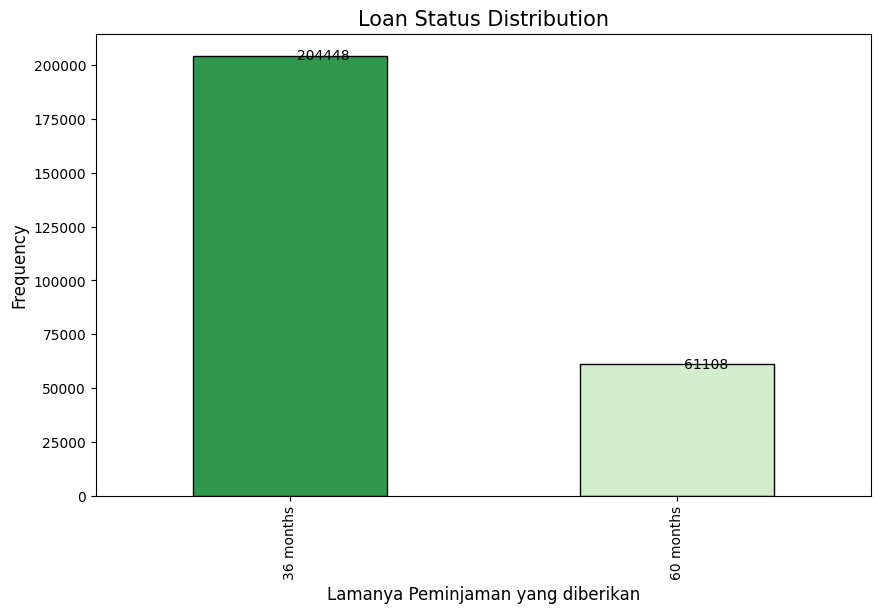

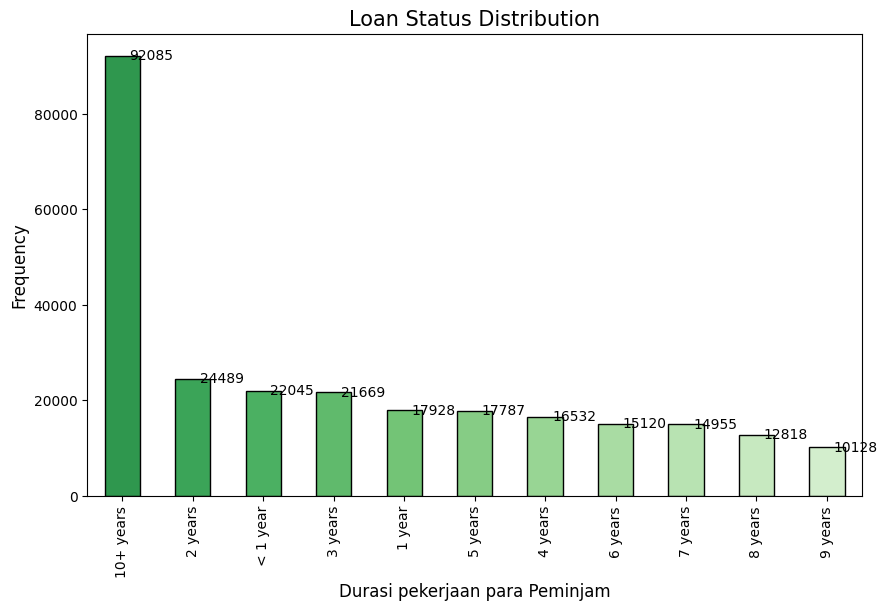

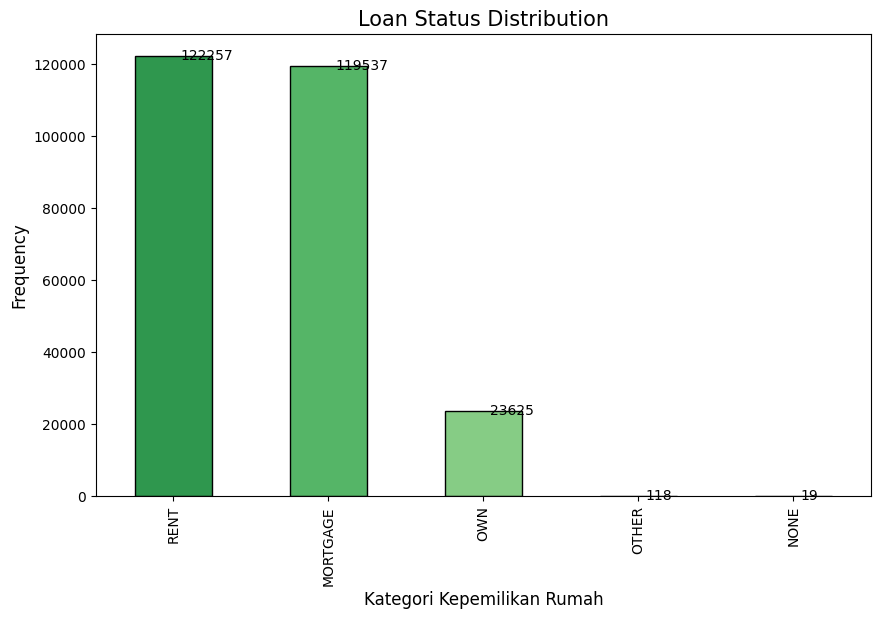

In [49]:
# Grafik Histogram
def histogram(column, df, xlabel):
    df_counts = df[column].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    colors = plt.get_cmap('Greens')(np.linspace(0.7, 0.2, len(df_counts)))

    ax = df_counts.plot(kind='bar', color=colors, edgecolor='black')

    for index, value in enumerate(df_counts):
        ax.annotate(f'{value}', xy=(index, value),
                    xytext=(5, 0), textcoords='offset points',
                    ha='left', va='center', fontsize=10, color='black')

    plt.title('Loan Status Distribution', fontsize=15)
    plt.xlabel(f'{xlabel}', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.show()



histogram("term",df_after_outlier,"Lamanya Peminjaman yang diberikan")
histogram("emp_length",df_after_outlier,"Durasi pekerjaan para Peminjam")
histogram("home_ownership",df_after_outlier,"Kategori Kepemilikan Rumah")


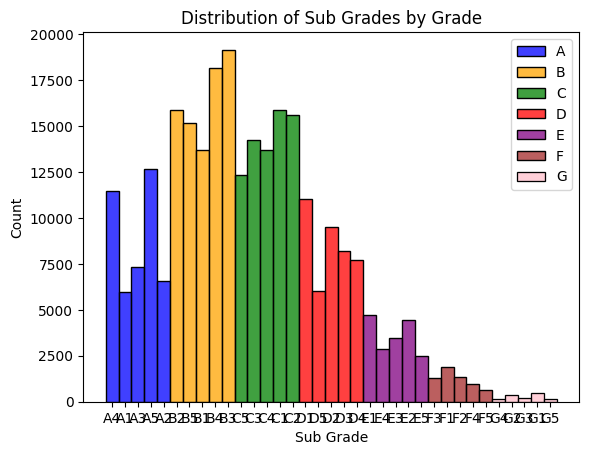

In [50]:
palette = {
    'A': 'blue',
    'B': 'orange',
    'C': 'green',
    'D': 'red',
    'E': 'purple',
    'F': 'brown',
    'G': 'pink'
}
for grade, sub_df in df_after_outlier.groupby('grade'):
    color = palette[grade]
    sns.histplot(data=sub_df, x='sub_grade', color=color, label=grade, discrete=True)

plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.title('Distribution of Sub Grades by Grade')
plt.legend()

plt.show()


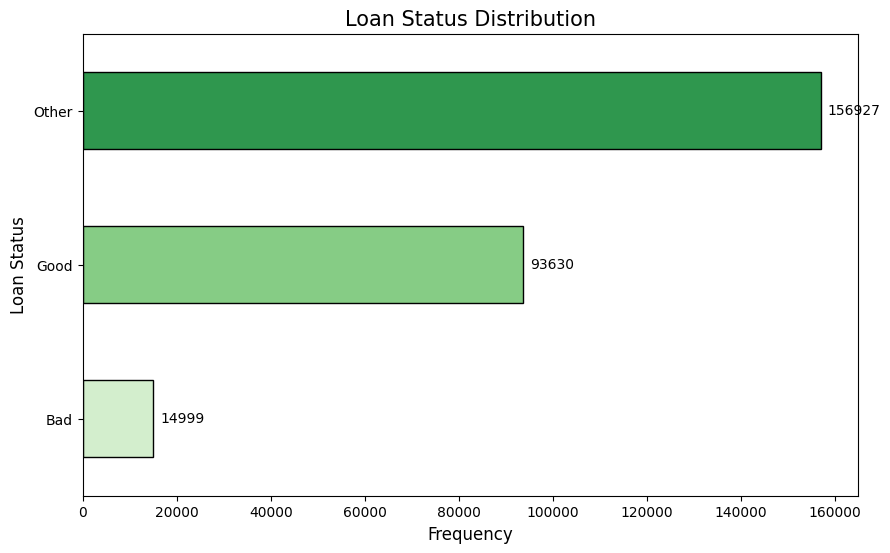

In [51]:
loan_status_counts = df_after_outlier['loan_status_category'].value_counts().sort_values(ascending = True)
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('Greens')(np.linspace(0.2, 0.7,len(loan_status_counts)))


ax = loan_status_counts.plot(kind='barh', color=colors, edgecolor='black')

for index, value in enumerate(loan_status_counts):
    ax.annotate(f'{value}', xy=(value, index),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=10, color='black')

plt.title('Loan Status Distribution', fontsize=15)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Loan Status', fontsize=12)

plt.show()


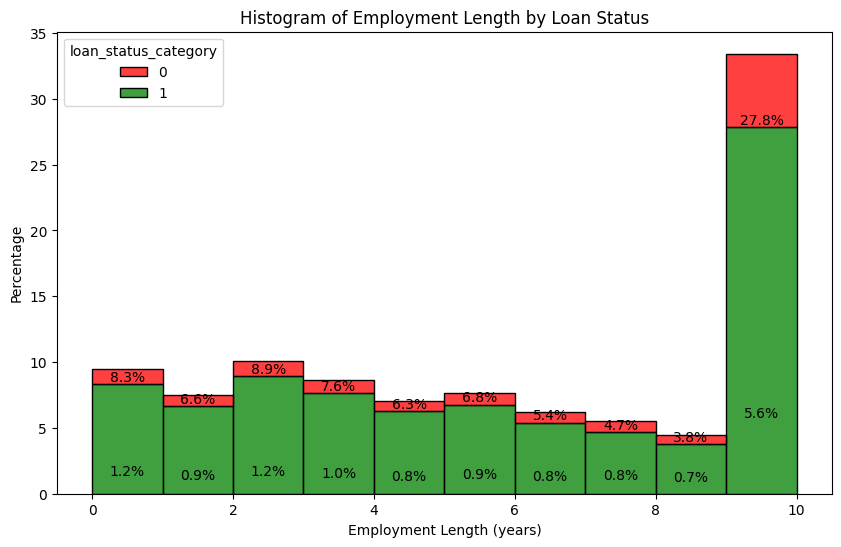

In [52]:

palette = {1: 'green', 0: 'red'}
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_cleaned_new, x='emp_length', hue='loan_status_category', multiple='stack', bins=10, palette=palette, stat='percent')

# Tambahkan label sumbu x, y, dan judul
plt.title('Histogram of Employment Length by Loan Status')
plt.xlabel('Employment Length (years)')
plt.ylabel('Percentage')

# Tambahkan teks persentase di atas setiap bin
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.show()

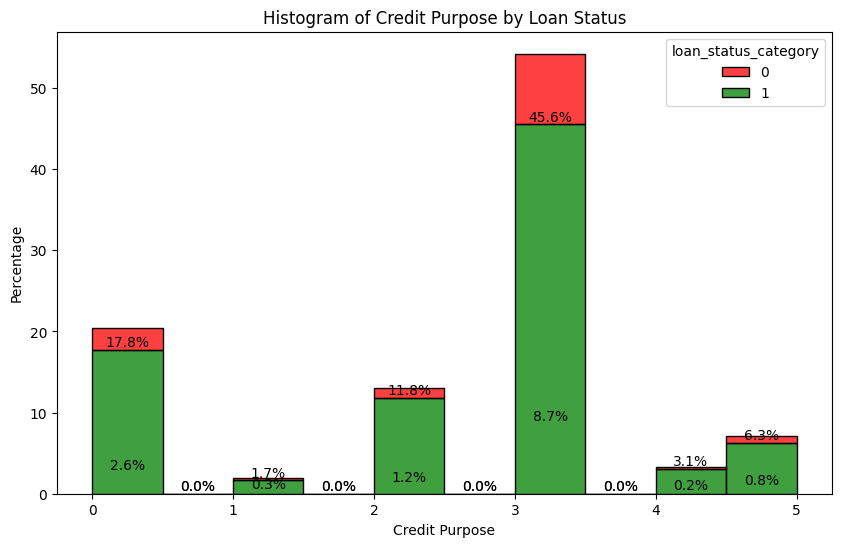

In [53]:
palette = {1: 'green', 0: 'red'}
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_cleaned_new, x='purpose', hue='loan_status_category', multiple='stack', bins=10, palette=palette, stat='percent')

# Tambahkan label sumbu x, y, dan judul
plt.title('Histogram of Credit Purpose by Loan Status')
plt.xlabel('Credit Purpose')
plt.ylabel('Percentage')

# Tambahkan teks persentase di atas setiap bin
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.show()

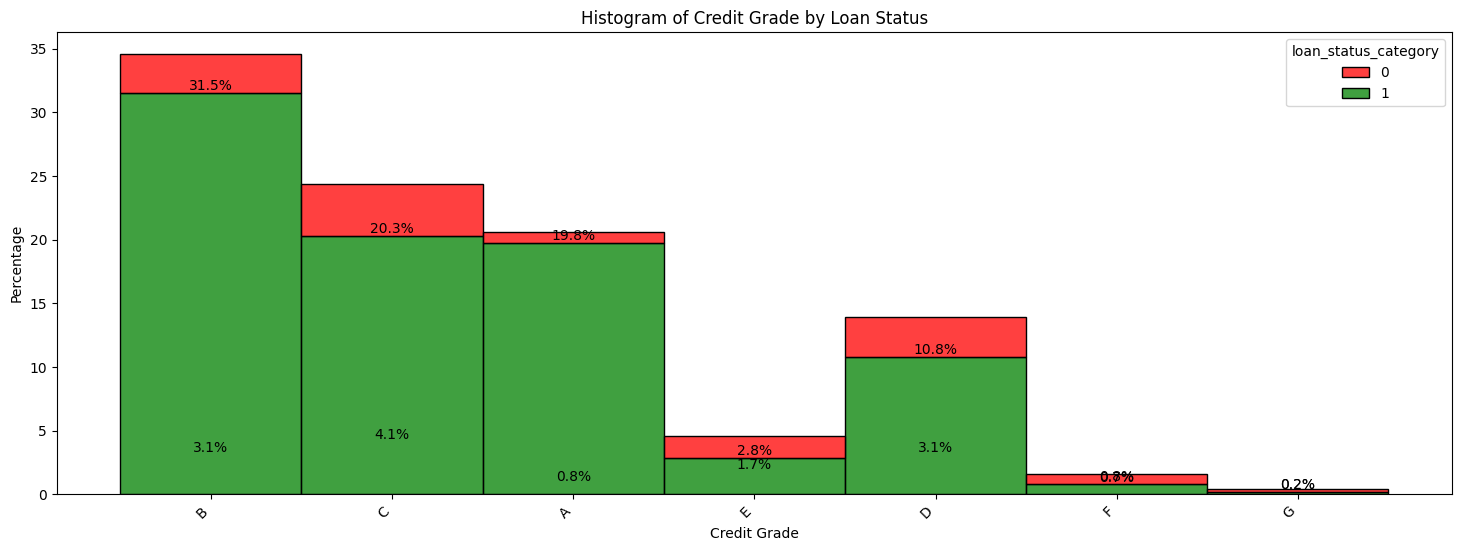

In [54]:
grade_mapping = {
    6: 'A',
    5: 'B',
    4: 'C',
    3: 'D',
    2: 'E',
    1: 'F',
    0: 'G'
}

grade_labels = df_cleaned_new['grade'].map(grade_mapping)

plt.figure(figsize=(18, 6))
ax = sns.histplot(data=df_cleaned_new, x=grade_labels, hue='loan_status_category', multiple='stack', bins=10, palette=palette, stat='percent')

plt.title('Histogram of Credit Grade by Loan Status')
plt.xlabel('Credit Grade')
plt.ylabel('Percentage')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')

plt.show()

# Data Modeling

## Split Data

In [55]:
df_cleaned_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108629 entries, 0 to 265553
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   term                         108629 non-null  int64  
 1   int_rate                     108629 non-null  float64
 2   installment                  108629 non-null  float64
 3   grade                        108629 non-null  int64  
 4   emp_length                   108629 non-null  int64  
 5   home_ownership               108629 non-null  int64  
 6   annual_inc                   108629 non-null  float64
 7   verification_status          108629 non-null  int64  
 8   pymnt_plan                   108629 non-null  int64  
 9   purpose                      108629 non-null  int64  
 10  dti                          108629 non-null  float64
 11  delinq_2yrs                  108629 non-null  float64
 12  inq_last_6mths               108629 non-null  float64
 13  mths

In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_cleaned_new.drop(columns='loan_status_category'),
                                                    df_cleaned_new['loan_status_category'],
                                                    test_size=0.3,
                                                    random_state=42)

In [57]:
print(X_train.shape)
print(X_test.shape)


(76040, 36)
(32589, 36)


## Standarization

Periksa terkait persebaran datanya, apakah persebaran data atau distribusi data dianggap normal atau tidak.

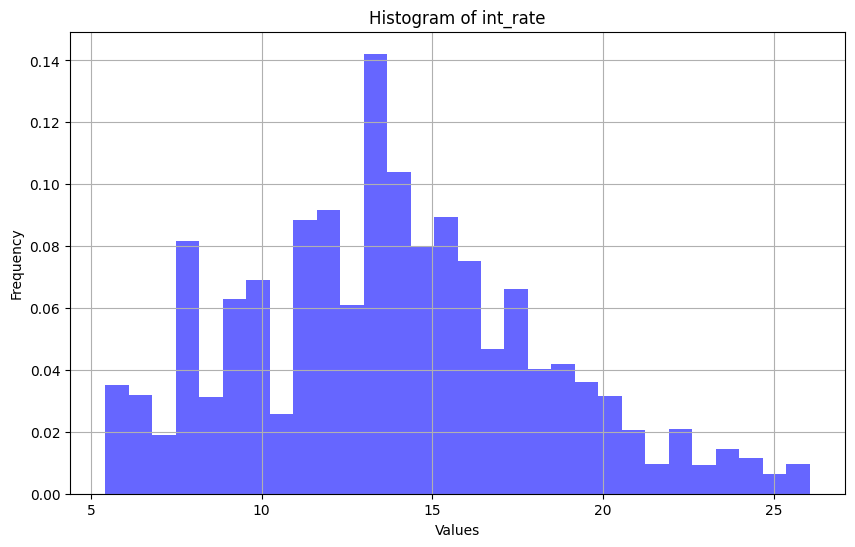

<Figure size 1000x600 with 0 Axes>

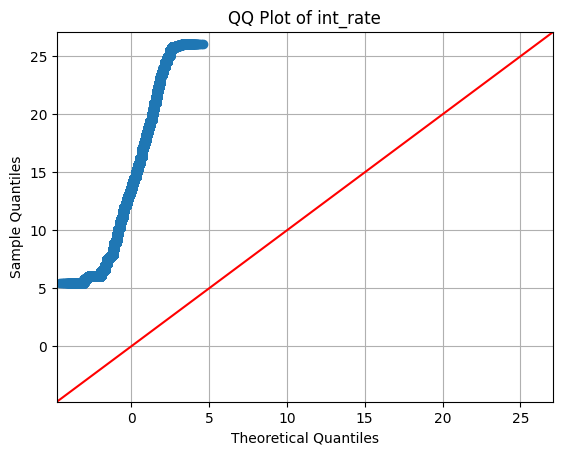

int_rate: Data does not follow a normal distribution (reject H0)


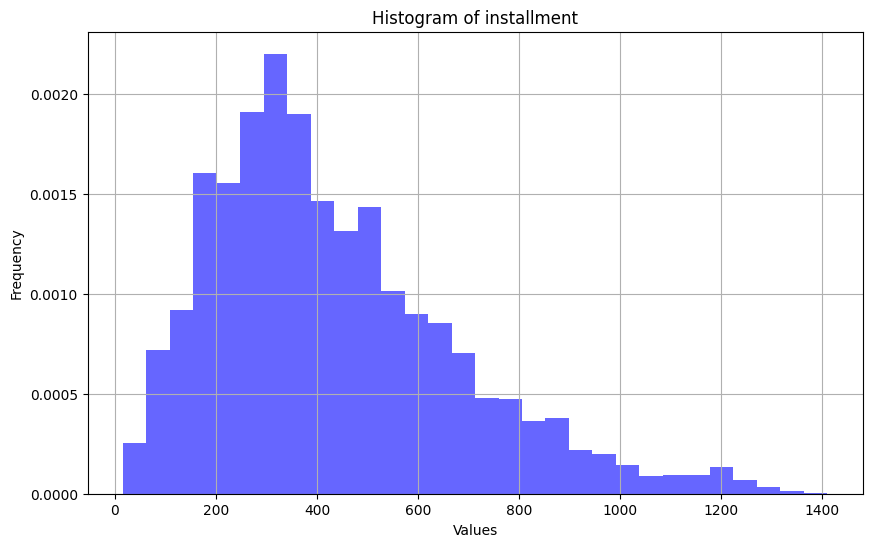

<Figure size 1000x600 with 0 Axes>

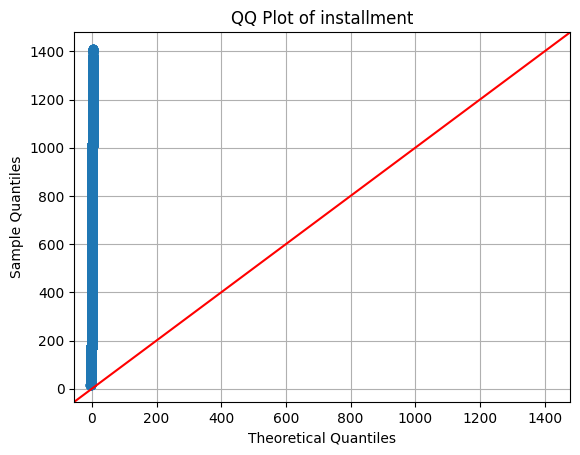

installment: Data does not follow a normal distribution (reject H0)


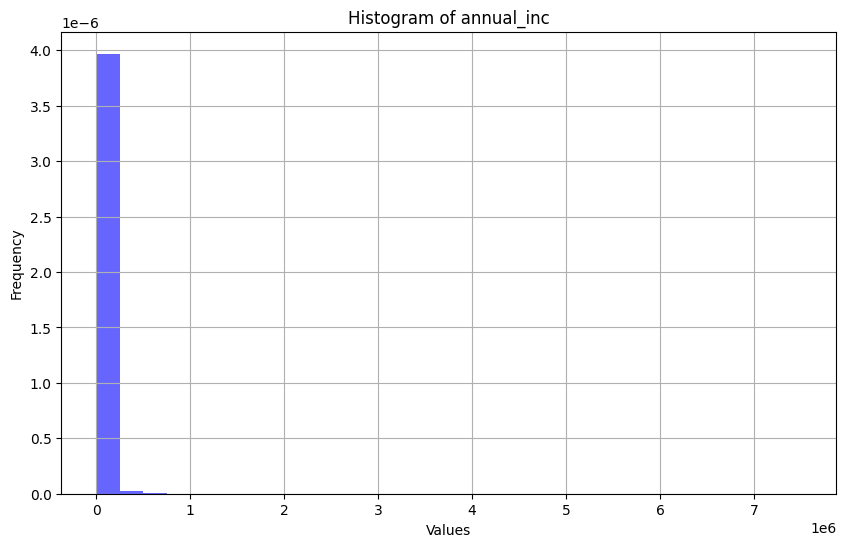

<Figure size 1000x600 with 0 Axes>

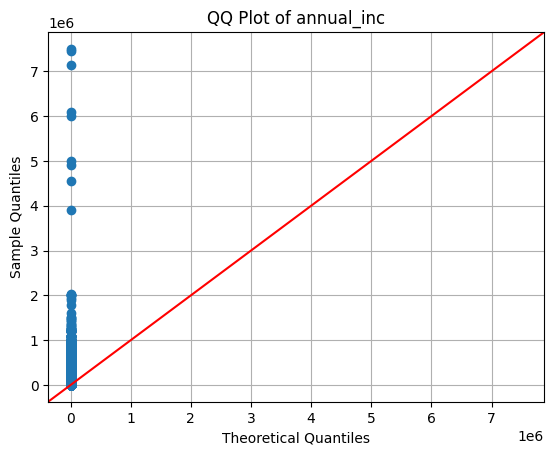

annual_inc: Data does not follow a normal distribution (reject H0)


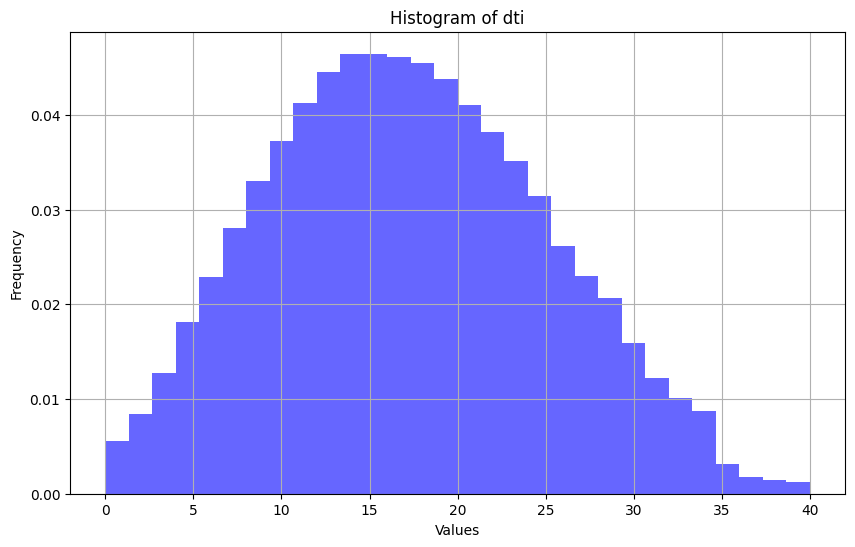

<Figure size 1000x600 with 0 Axes>

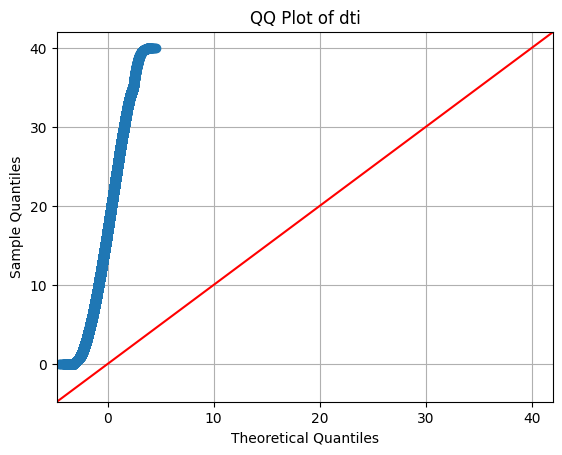

dti: Data does not follow a normal distribution (reject H0)


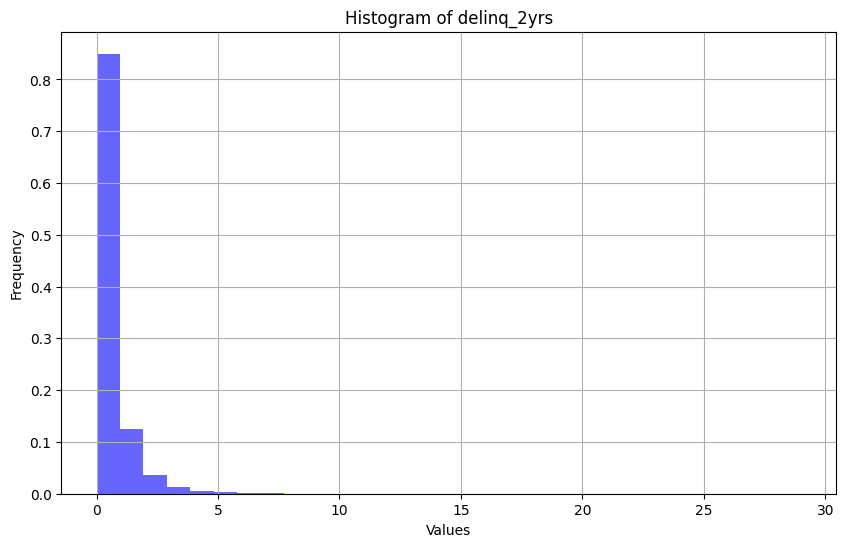

<Figure size 1000x600 with 0 Axes>

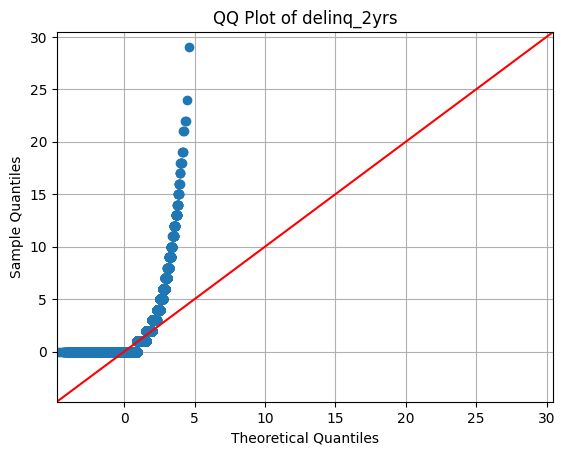

delinq_2yrs: Data does not follow a normal distribution (reject H0)


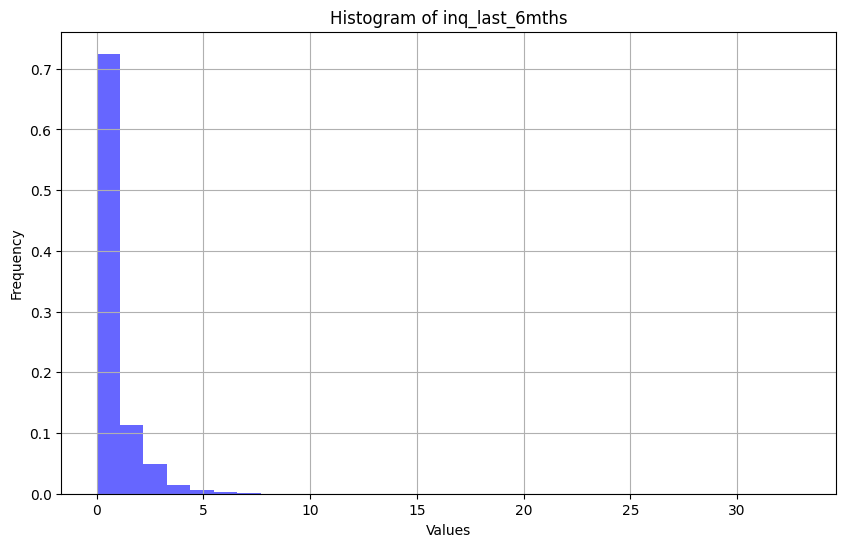

<Figure size 1000x600 with 0 Axes>

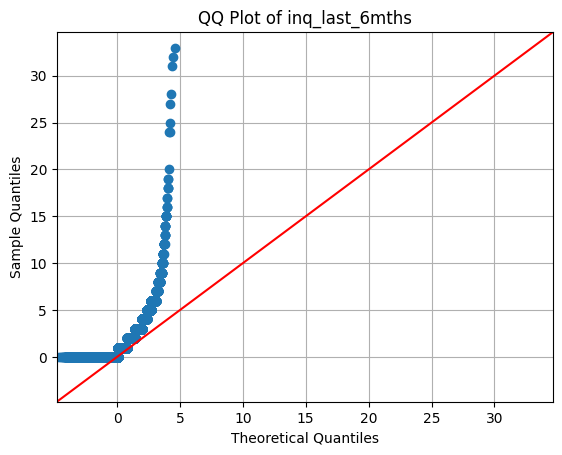

inq_last_6mths: Data does not follow a normal distribution (reject H0)


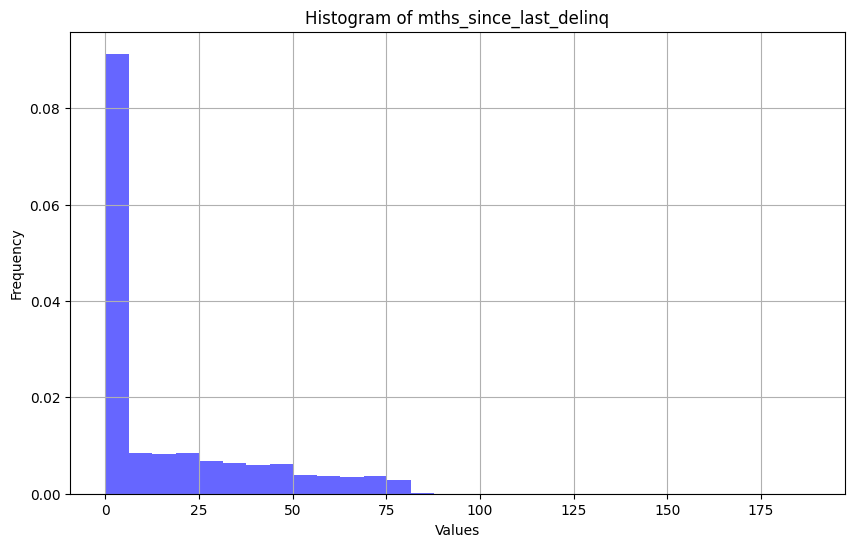

<Figure size 1000x600 with 0 Axes>

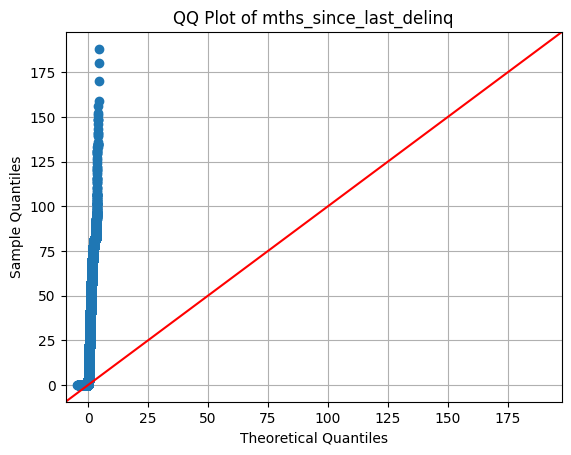

mths_since_last_delinq: Data does not follow a normal distribution (reject H0)


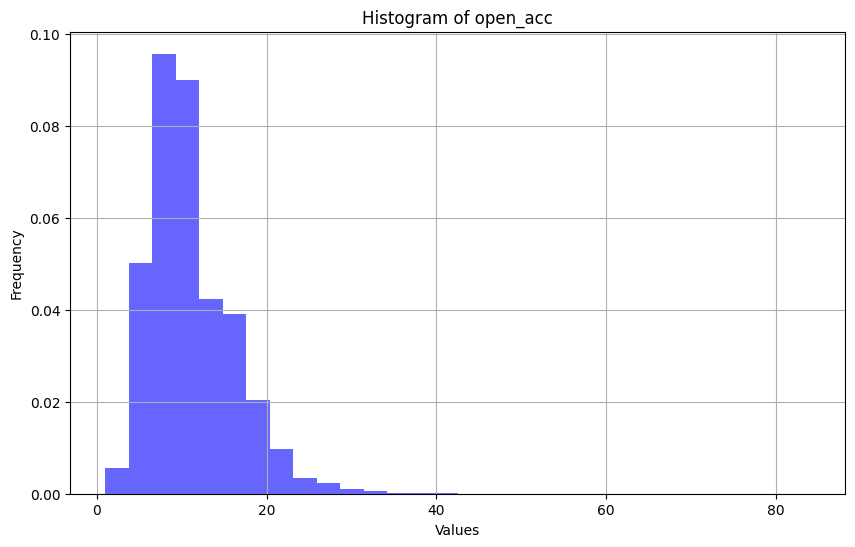

<Figure size 1000x600 with 0 Axes>

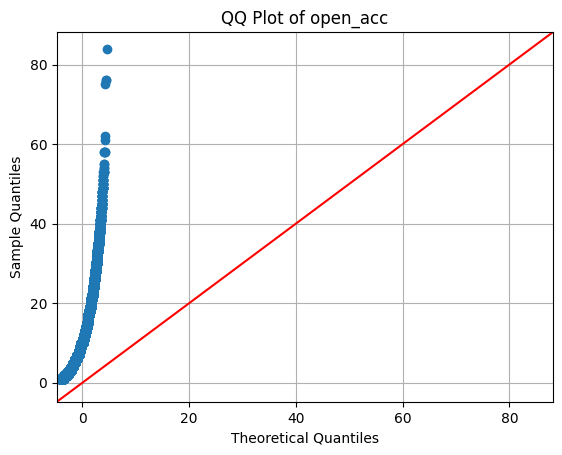

open_acc: Data does not follow a normal distribution (reject H0)


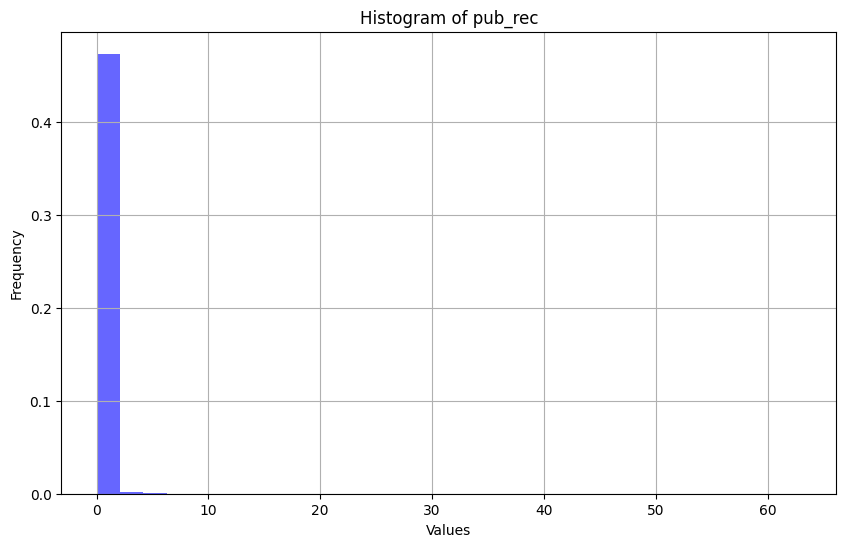

<Figure size 1000x600 with 0 Axes>

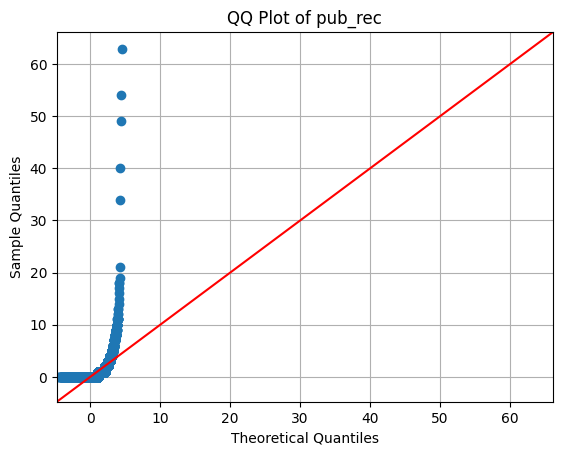

pub_rec: Data does not follow a normal distribution (reject H0)


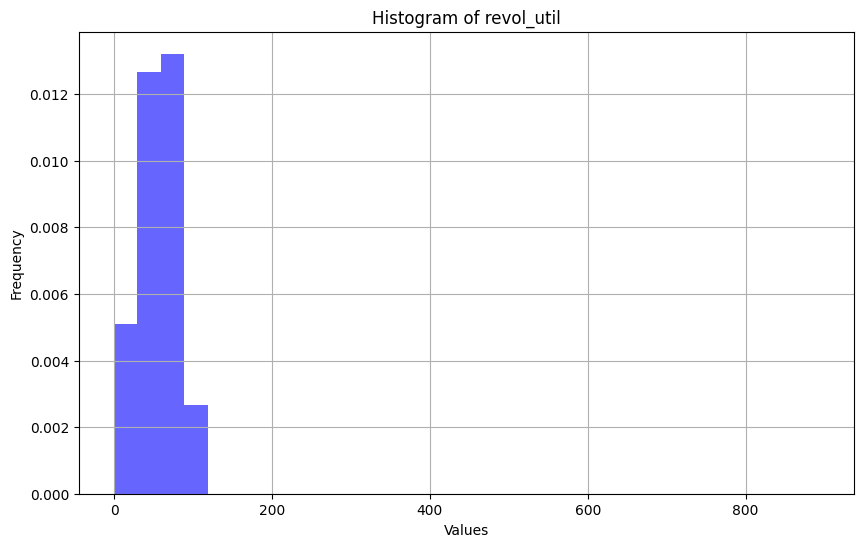

<Figure size 1000x600 with 0 Axes>

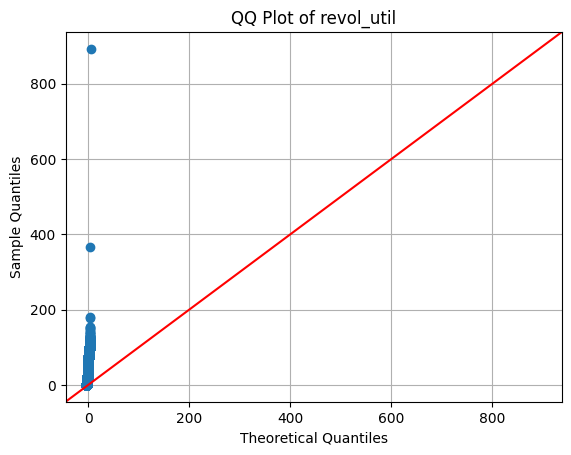

revol_util: Data does not follow a normal distribution (reject H0)


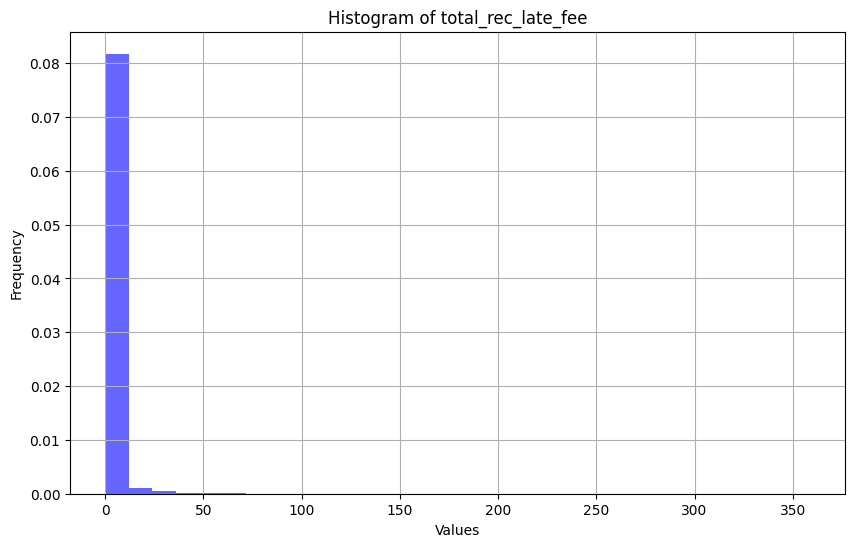

<Figure size 1000x600 with 0 Axes>

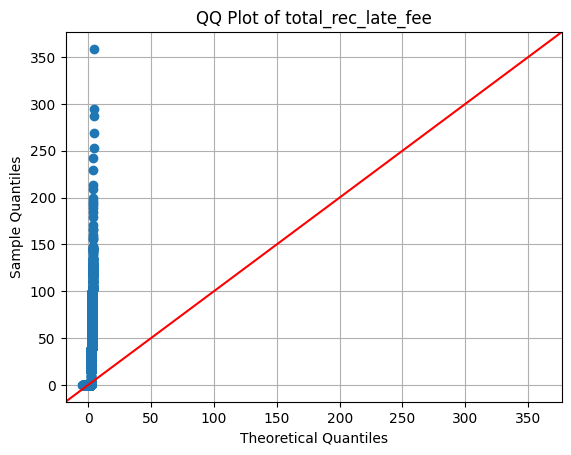

total_rec_late_fee: Data does not follow a normal distribution (reject H0)


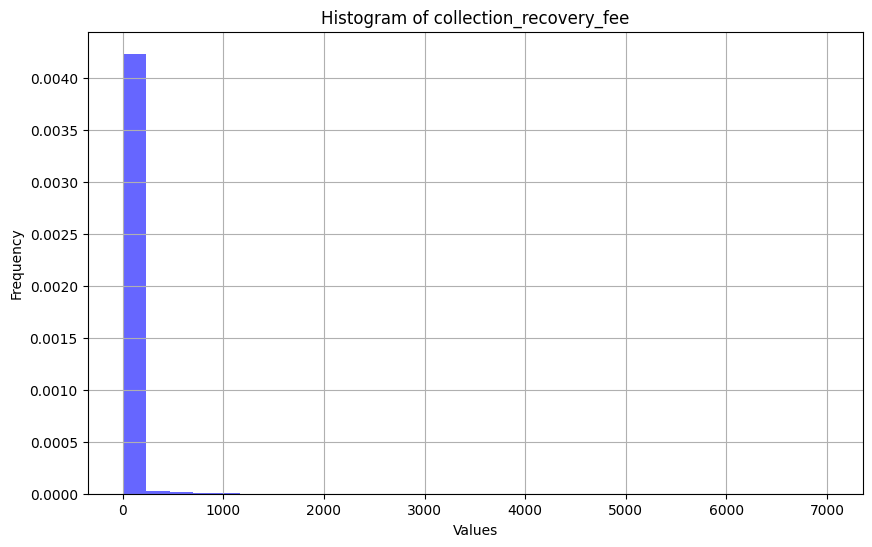

<Figure size 1000x600 with 0 Axes>

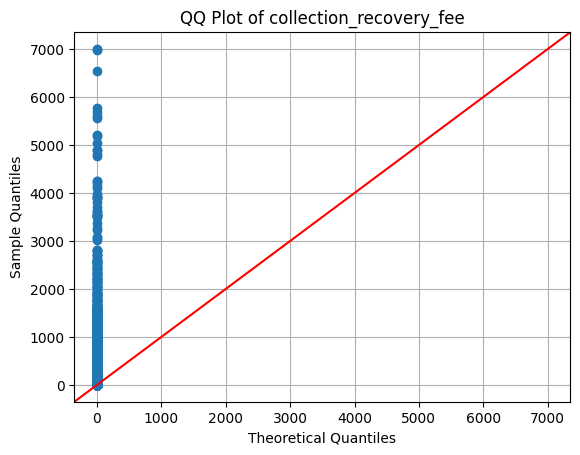

collection_recovery_fee: Data does not follow a normal distribution (reject H0)


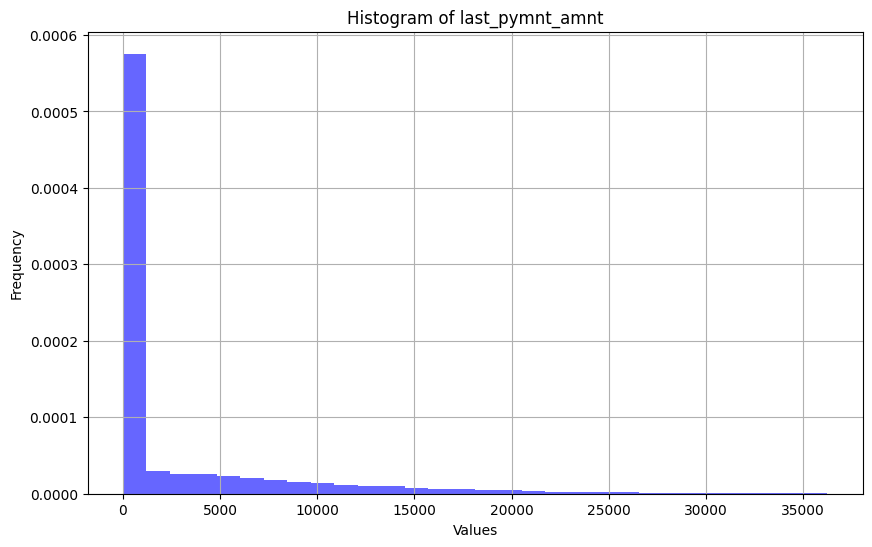

<Figure size 1000x600 with 0 Axes>

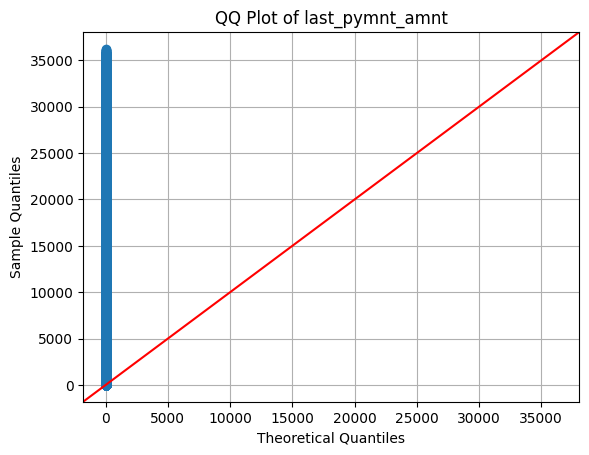

last_pymnt_amnt: Data does not follow a normal distribution (reject H0)


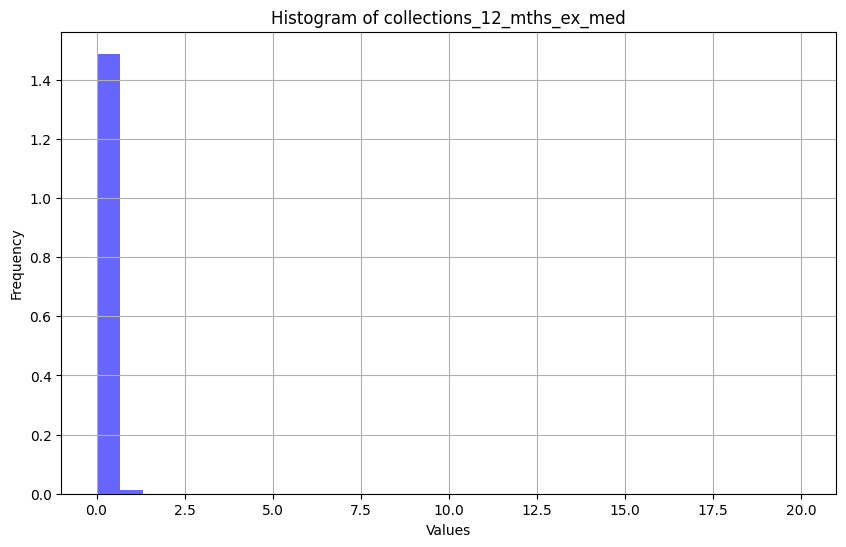

<Figure size 1000x600 with 0 Axes>

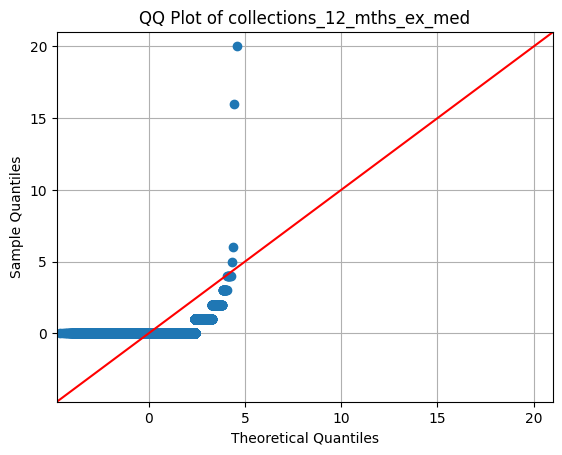

collections_12_mths_ex_med: Data does not follow a normal distribution (reject H0)


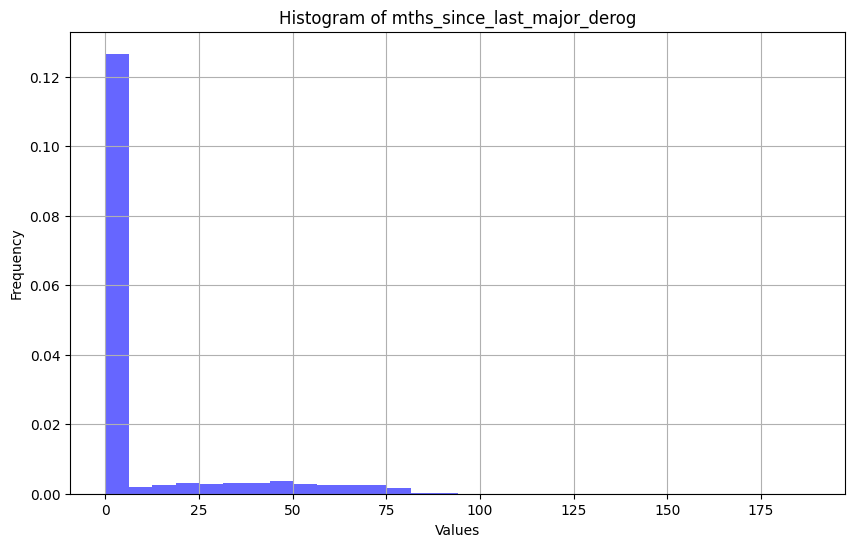

<Figure size 1000x600 with 0 Axes>

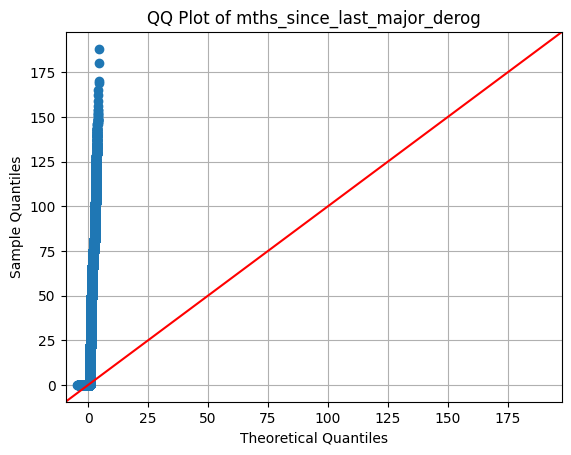

mths_since_last_major_derog: Data does not follow a normal distribution (reject H0)


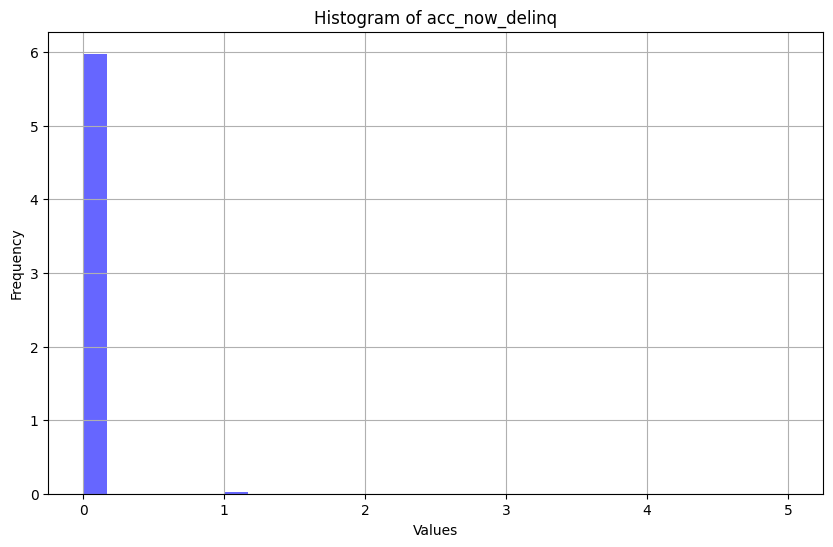

<Figure size 1000x600 with 0 Axes>

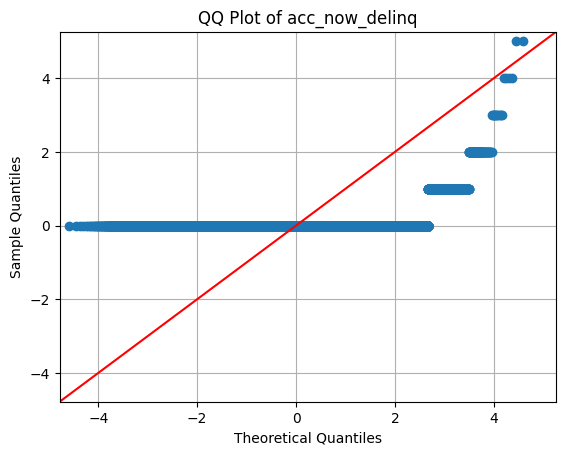

acc_now_delinq: Data does not follow a normal distribution (reject H0)


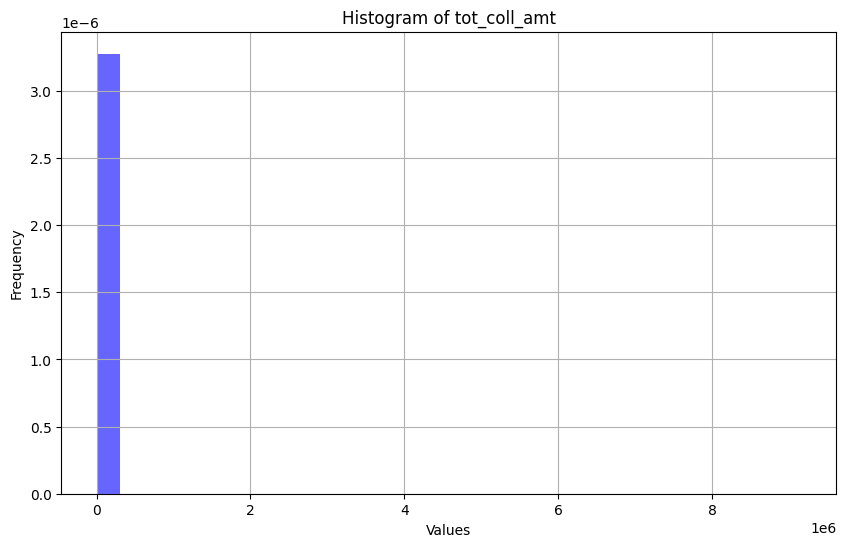

<Figure size 1000x600 with 0 Axes>

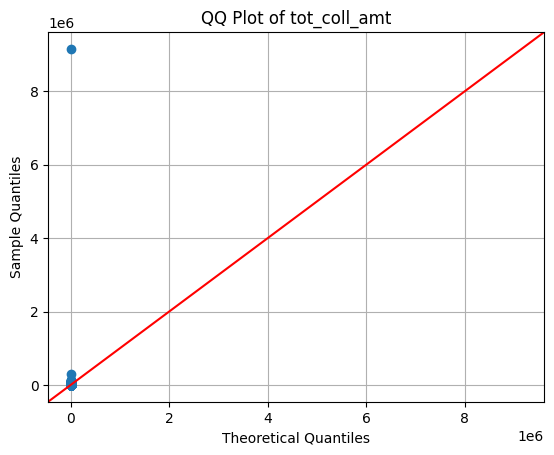

tot_coll_amt: Data does not follow a normal distribution (reject H0)


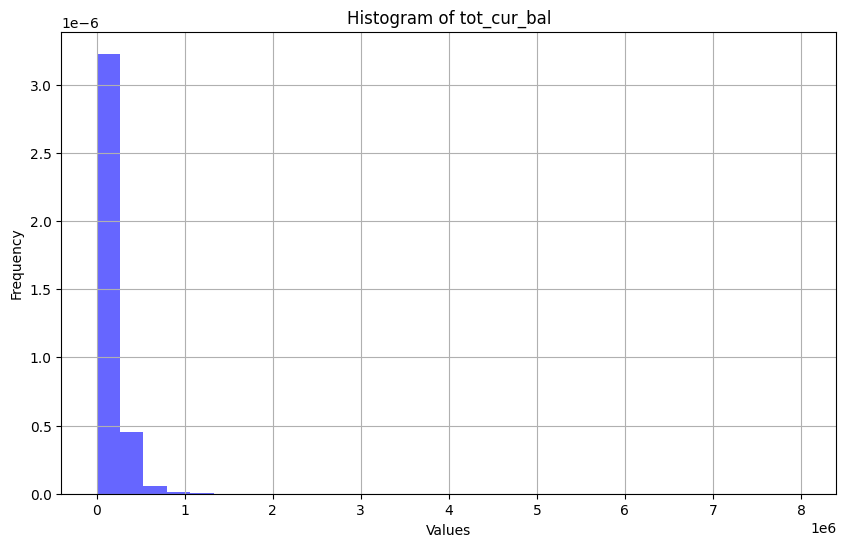

<Figure size 1000x600 with 0 Axes>

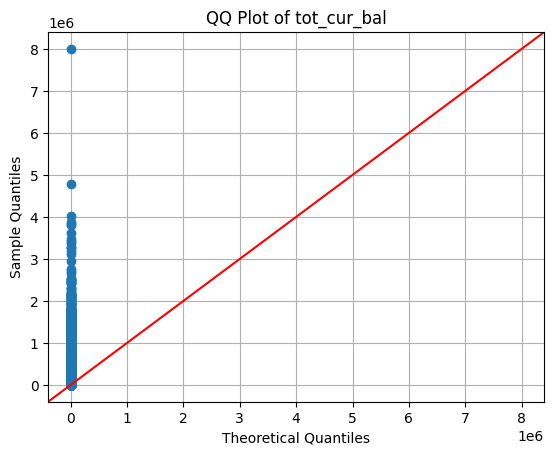

tot_cur_bal: Data does not follow a normal distribution (reject H0)


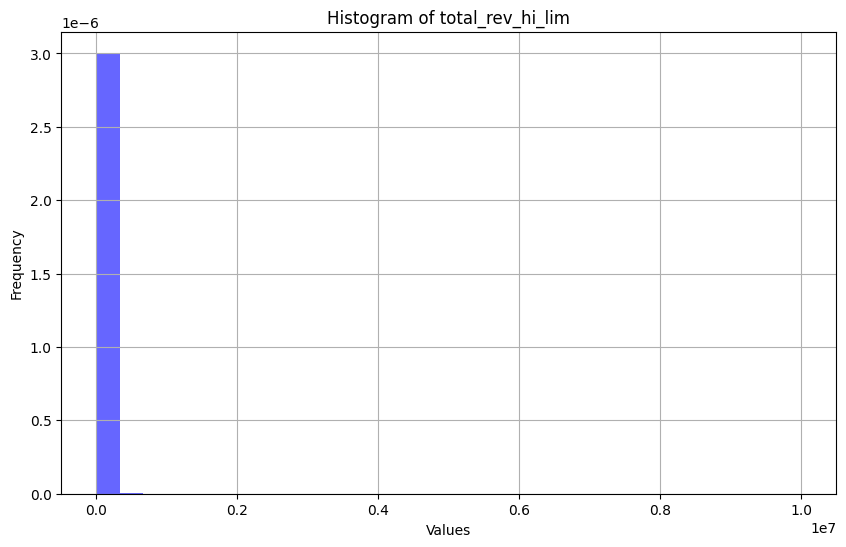

<Figure size 1000x600 with 0 Axes>

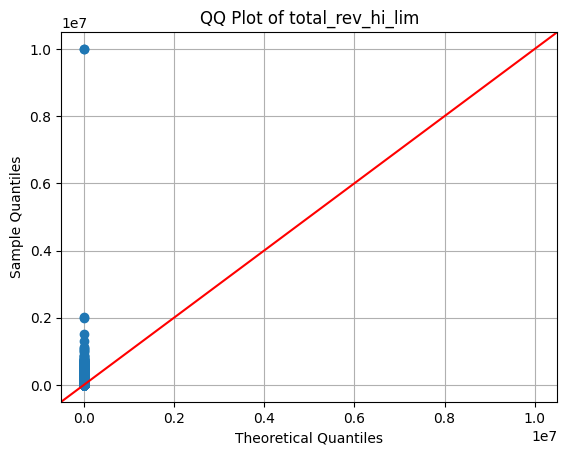

total_rev_hi_lim: Data does not follow a normal distribution (reject H0)


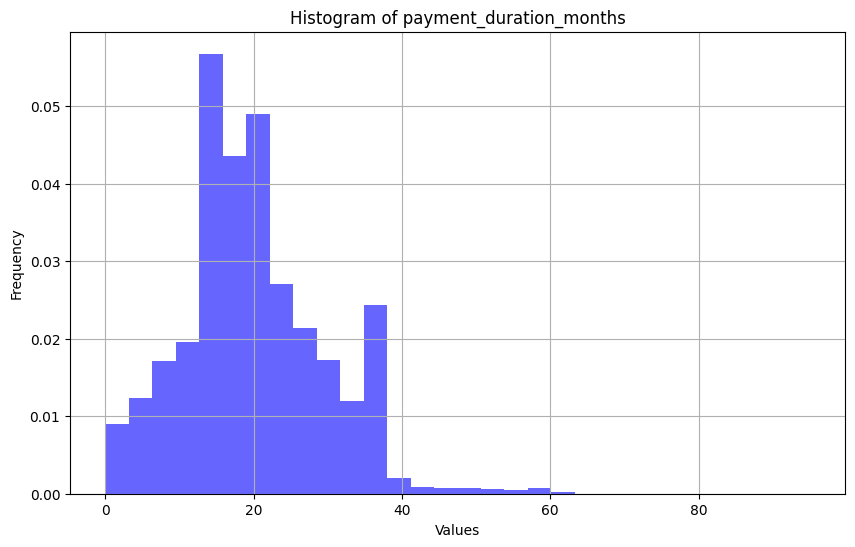

<Figure size 1000x600 with 0 Axes>

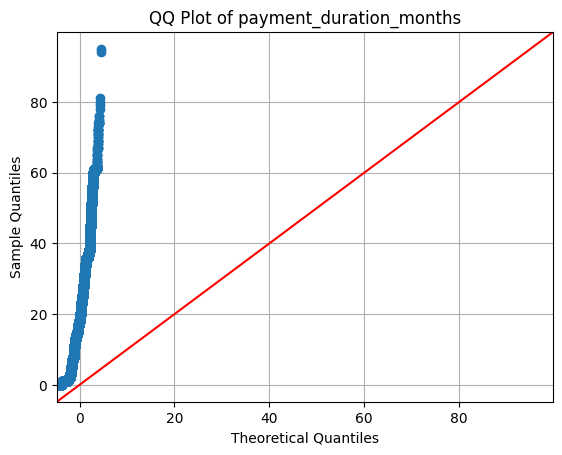

payment_duration_months: Data does not follow a normal distribution (reject H0)


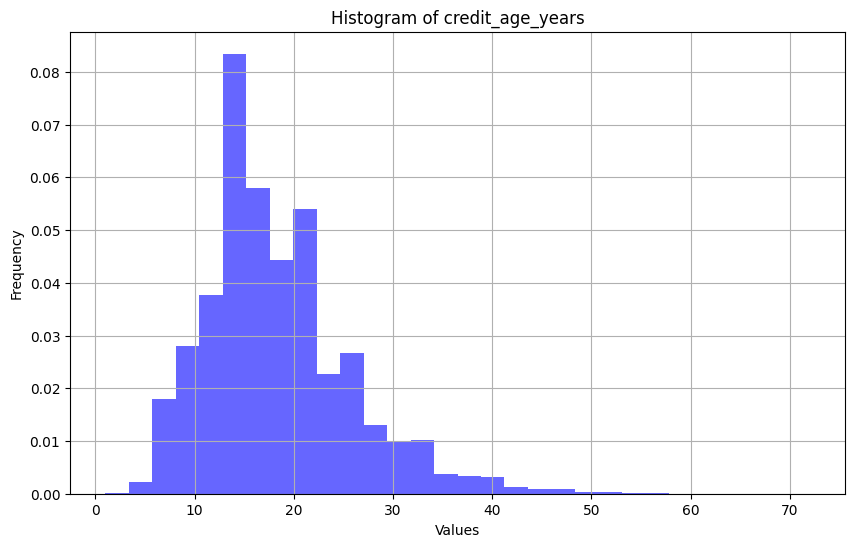

<Figure size 1000x600 with 0 Axes>

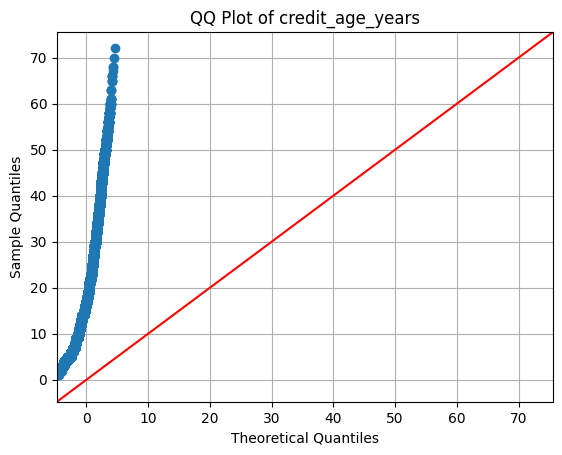

credit_age_years: Data does not follow a normal distribution (reject H0)


In [58]:
# Histogram
def evaluate_normality(df):
    for column in df.columns:
        data = df[column]

        # Histogram
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=30, density=True, alpha=0.6, color='b')
        plt.title(f'Histogram of {column}')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # QQ Plot
        plt.figure(figsize=(10, 6))
        sm.qqplot(data, line ='45')
        plt.title(f'QQ Plot of {column}')
        plt.grid(True)
        plt.show()

        # Kolmogorov-Smirnov Test
        stat, p = stats.kstest(data, 'norm')
        alpha = 0.05
        if p > alpha:
            print(f"{column}: Data follows a normal distribution (fail to reject H0)")
        else:
            print(f"{column}: Data does not follow a normal distribution (reject H0)")

evaluate_normality(numeric_df)

Karena semuanya tidak memenuhi distribusi normal, maka perlu dilakukan log transform

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def log_transform(x):
  return np.log(x + 1)

# Pipeline to transform the numerical features
numerical = ['int_rate','installment','annual_inc','dti','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','open_acc',
             'revol_util','total_rec_late_fee','collection_recovery_fee','last_pymnt_amnt','mths_since_last_major_derog','tot_coll_amt',
             'tot_cur_bal','total_rev_hi_lim','payment_duration_months','credit_age_years']
skewed = ['installment','annual_inc','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','open_acc',
          'revol_util','total_rec_late_fee','collection_recovery_fee','last_pymnt_amnt','mths_since_last_major_derog','tot_coll_amt',
          'tot_cur_bal','total_rev_hi_lim','payment_duration_months','credit_age_years']
diff = list(set(numerical) - set(skewed))

smt = SMOTE(random_state=42)
ss = StandardScaler()
log_transformer = FunctionTransformer(log_transform)

numerical_transformer = Pipeline([('log', log_transformer),('ss', ss)])
ct = ColumnTransformer([('num_transformer', numerical_transformer, skewed), ('scaler', ss, diff)], remainder='passthrough')



## Declare Metrics Evaluation

In [60]:
from sklearn.metrics import roc_auc_score,confusion_matrix
from scipy.stats import ks_2samp
import pandas as pd

def evaluate_ks_and_roc_auc(y_true, y_pred_prob):
    # Combine actual and predicted probbilities into a DataFrame
    df = pd.DataFrame()
    df['actual'] = y_true
    df['predicted_prob'] = y_pred_prob[:, 1]

    # Filter each class
    class_0 = df[df['actual'] == 0]
    class_1 = df[df['actual'] == 1]

    # Compute KS statistic
    ks_statistic, ks_pvalue = ks_2samp(class_0['predicted_prob'], class_1['predicted_prob'])

    # Compute ROC AUC score
    roc_auc = roc_auc_score(df['actual'], df['predicted_prob'])

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"KS Statistic: {ks_statistic:.4f} (p-value: {ks_pvalue:.3e})")

    return ks_statistic, roc_auc


# Train Model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training is success!
ROC AUC Score: 0.9487
KS Statistic: 0.8388 (p-value: 0.000e+00)
Classification report Logistic Regression:
               precision    recall  f1-score   support

           0       0.62      0.91      0.74      4426
           1       0.98      0.91      0.95     28163

    accuracy                           0.91     32589
   macro avg       0.80      0.91      0.84     32589
weighted avg       0.94      0.91      0.92     32589



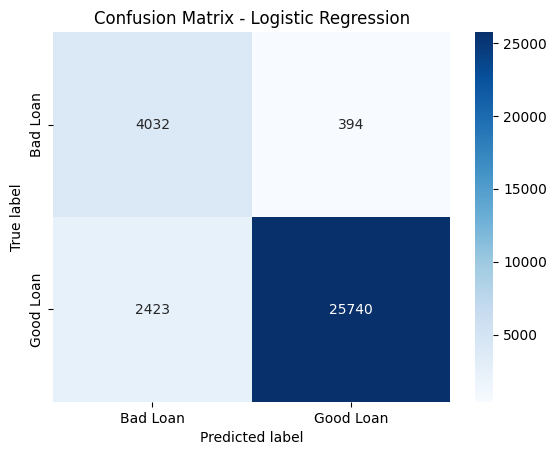

In [61]:
# Main pipeline for fitting.
model_LR = Pipeline([
                   ('column_transformer', ct),
                   ('smt', smt),
                   ('RF', LogisticRegression(random_state=42) )
          ])
model_LR.fit(X_train, y_train)
print("Training is success!")
y_pred = model_LR.predict_proba(X_test)
predicted = model_LR.predict(X_test)
#print AUC, KS score, and classification report
ks, auc = evaluate_ks_and_roc_auc(y_test, y_pred)
matrix = classification_report(y_test, predicted)
print('Classification report Logistic Regression:\n', matrix)

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, predicted)
plt.title('Confusion Matrix - Logistic Regression')
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad Loan", "Good Loan"], yticklabels=["Bad Loan", "Good Loan"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Training is success!
ROC AUC Score: 0.9872
KS Statistic: 0.9201 (p-value: 0.000e+00)
Classification report Random Forest:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      4426
           1       0.99      0.97      0.98     28163

    accuracy                           0.96     32589
   macro avg       0.90      0.95      0.93     32589
weighted avg       0.97      0.96      0.96     32589



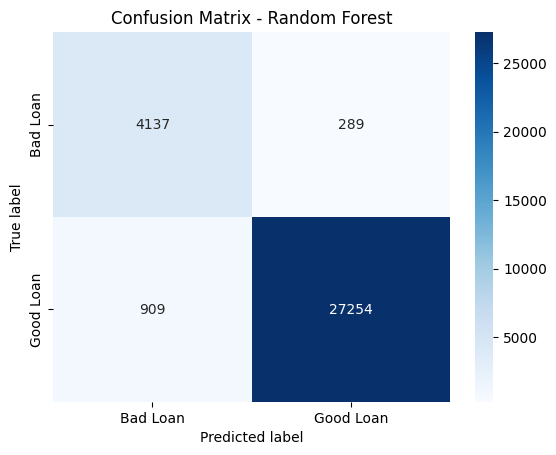

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Main pipeline for Random Forest fitting.
model_RF = Pipeline([
                   ('column_transformer', ct),
                   ('smt', smt),
                   ('RF', RandomForestClassifier(random_state=42))
          ])
model_RF.fit(X_train, y_train)
print("Training is success!")
y_pred = model_RF.predict_proba(X_test)
predicted = model_RF.predict(X_test)

# AUC, KS score, and classification report
ks, auc = evaluate_ks_and_roc_auc(y_test, y_pred)
matrix = classification_report(y_test, predicted)
print('Classification report Random Forest:\n', matrix)

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, predicted)
plt.title('Confusion Matrix - Random Forest')
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad Loan", "Good Loan"], yticklabels=["Bad Loan", "Good Loan"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Training is success!
ROC AUC Score: 0.9875
KS Statistic: 0.9210 (p-value: 0.000e+00)
Classification report Gradient Boosting:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      4426
           1       0.99      0.96      0.98     28163

    accuracy                           0.96     32589
   macro avg       0.89      0.96      0.92     32589
weighted avg       0.96      0.96      0.96     32589



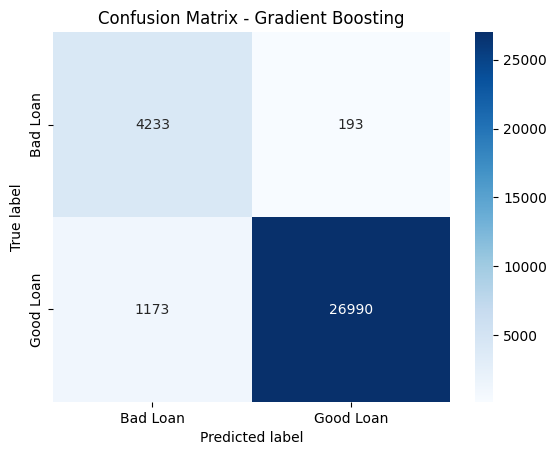

In [69]:
# Main pipeline for fitting.
from sklearn.ensemble import GradientBoostingClassifier

model_GB = Pipeline([
                   ('column_transformer', ct),
                   ('smt', smt),
                   ('GB', GradientBoostingClassifier(random_state=42) )
          ])
model_GB.fit(X_train, y_train)
print("Training is success!")
y_pred = model_GB.predict_proba(X_test)
predicted = model_GB.predict(X_test)
# AUC, KS score, and classification report
ks, auc = evaluate_ks_and_roc_auc(y_test, y_pred)
matrix = classification_report(y_test, predicted)
print('Classification report Gradient Boosting:\n', matrix)

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, predicted)
plt.title('Confusion Matrix - Gradient Boosting')
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad Loan", "Good Loan"], yticklabels=["Bad Loan", "Good Loan"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#Hyper Parameter Tuning

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters for Logistic Regression: {'RF__C': 1, 'RF__penalty': 'l2'}
ROC AUC Score: 0.9487
KS Statistic: 0.8388 (p-value: 0.000e+00)
Classification report Logistic Regression (Tuned):
               precision    recall  f1-score   support

           0       0.62      0.91      0.74      4426
           1       0.98      0.91      0.95     28163

    accuracy                           0.91     32589
   macro avg       0.80      0.91      0.84     32589
weighted avg       0.94      0.91      0.92     32589



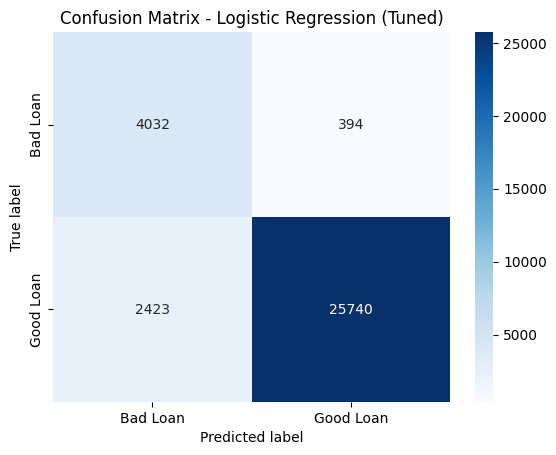

In [63]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid_LR = {
    'RF__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'RF__penalty': ['l1', 'l2']  # Regularization penalty
}

# Main pipeline for Logistic Regression fitting.
model_LR_tuned = Pipeline([
                   ('column_transformer', ct),
                   ('smt', smt),
                   ('RF', LogisticRegression(random_state=42))
          ])

# Grid search cross validation
grid_LR = GridSearchCV(model_LR_tuned, param_grid_LR, cv=5, scoring='roc_auc')
grid_LR.fit(X_train, y_train)

# Best parameters
print("Best parameters for Logistic Regression:", grid_LR.best_params_)

# Predictions and evaluation
y_pred_LR_tuned = grid_LR.predict_proba(X_test)
predicted_LR_tuned = grid_LR.predict(X_test)
ks_LR_tuned, auc_LR_tuned = evaluate_ks_and_roc_auc(y_test, y_pred_LR_tuned)
matrix_LR_tuned = classification_report(y_test, predicted_LR_tuned)
print('Classification report Logistic Regression (Tuned):\n', matrix_LR_tuned)

# Plot confusion matrix
cf_matrix_LR_tuned = confusion_matrix(y_test, predicted_LR_tuned)
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
sns.heatmap(cf_matrix_LR_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad Loan", "Good Loan"], yticklabels=["Bad Loan", "Good Loan"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define parameter grid for Gradient Boosting Classifier
param_grid_GB = {
    'GB__n_estimators': [50, 100, 150],  # Number of boosting stages
    'GB__learning_rate': [0.01, 0.1, 0.5],  # Learning rate shrinks the contribution of each tree
    'GB__max_depth': [3, 5, 7]  # Maximum depth of the individual estimators
}

# Main pipeline for Gradient Boosting Classifier fitting
model_GB_tuned = Pipeline([
                   ('column_transformer', ct),
                   ('smt', smt),
                   ('GB', GradientBoostingClassifier(random_state=42))
])

# Grid search cross validation
grid_GB = GridSearchCV(model_GB_tuned, param_grid_GB, cv=5, scoring='roc_auc')
grid_GB.fit(X_train, y_train)

# Best parameters
print("Best parameters for Gradient Boosting Classifier:", grid_GB.best_params_)

# Predictions and evaluation
y_pred_GB_tuned = grid_GB.predict_proba(X_test)
predicted_GB_tuned = grid_GB.predict(X_test)
ks_GB_tuned, auc_GB_tuned = evaluate_ks_and_roc_auc(y_test, y_pred_GB_tuned)
matrix_GB_tuned = classification_report(y_test, predicted_GB_tuned)
print('Classification report Gradient Boosting Classifier (Tuned):\n', matrix_GB_tuned)

# Plot confusion matrix
cf_matrix_GB_tuned = confusion_matrix(y_test, predicted_GB_tuned)
plt.title('Confusion Matrix - Gradient Boosting Classifier (Tuned)')
sns.heatmap(cf_matrix_GB_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=["Bad Loan", "Good Loan"], yticklabels=["Bad Loan", "Good Loan"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


KeyboardInterrupt: 